<a href="https://colab.research.google.com/github/ominivac/analise_integraSUS/blob/master/Analise_de_dados_do_IntegraSUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import plotly
import numpy as np
import plotly.offline as py
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import seaborn as sns


# Fonte dos dados : http://download-integrasus.saude.ce.gov.br/download

In [198]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/IntegraSUS/casos_coronavirus_2020_12_22.csv", low_memory=False, sep=';')

QUANTIDADE DE ANTENDIMENTOS

In [199]:
#quantidade de registros
print('Nº de atendimentos : ' , df.shape )

Nº de atendimentos :  (1488301, 62)


In [200]:
# Preview dos dados , indentificação de colunas, fortmato dos dados etc
df.head(3)

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito
0,75db8bfe8c27ee18c6e9fe720f992b11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,30.0,30 a 34 anos,1990-08-13,NaN,NaT,NaN,2020-11-02 00:00:00,2020-11-02 00:00:00,Negativo,ARGOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f355aca43986fd453512d838e9be1d9d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,17.0,15 a 19 anos,2003-01-24,NaN,NaT,NaN,2020-11-29 00:00:00,2020-11-30 00:00:00,Negativo,ARGOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ce1f7ee971ee88f26f260cc4a588806a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,17.0,15 a 19 anos,2003-02-27,NaN,NaT,NaN,2020-11-29 00:00:00,2020-11-30 00:00:00,Negativo,ARGOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
df.dtypes

identificadorCaso             object
idRedcap                     float64
idEsus                        object
idSivep                      float64
classificacaoEstadoRedcap    float64
                              ...   
obitoConfirmado               object
dataObito                     object
classificacaoObito            object
localObito                    object
tipoLocalObito                object
Length: 62, dtype: object

In [202]:
# Tranformar as col. de data no tipo certo
df[["dataNotificacao","dataSolicitacaoExame","dataResultadoExame","dataColetaExame","dataInicioSintomas", "dataObito", "dataNotificacaoObito"]] =  df[["dataNotificacao","dataSolicitacaoExame","dataResultadoExame","dataColetaExame","dataInicioSintomas", "dataObito", "dataNotificacaoObito"]].apply(pd.to_datetime,  errors='coerce')

**1.1 Distribuição de atributos**

In [203]:
# Algumas colunas em brancos, contar para sexoPaciente
count = df["sexoCaso"].isnull().sum()
print(count)

4125


In [204]:
 # Ver distribuição de atributos
df['racaCor'].unique().tolist()

[nan,
 'Parda',
 'Branca',
 'Amarela',
 'Preta',
 'Sem Informacao',
 'Ignorado',
 'Indígena',
 'Indigena']

In [205]:
# Alterar onde for nan para Não Informado
df['racaCor'] = df['racaCor'].fillna('Não Informado')

In [206]:
df['tipoTesteExame'].unique().tolist()

['RT-PCR',
 nan,
 'Teste Rápido',
 'Não Informado',
 'Confirmado Clínico-Epidemiológico',
 'ELISA',
 'ECLIA',
 'Eletroquimioluminescência',
 'Confirmado por Critério Clínico',
 'Quimioluminescência',
 'Imunocromatografia',
 'CLIA',
 'Confirmado Clínico-Imagem']

In [207]:
df['evolucaoCasoSivep'].unique().tolist()

[nan, 'Cura', 'Óbito', 'Ignorado', '3']

In [208]:
df['comorbidadePneumopatiaSivep'].unique().tolist()

[nan, 'Não', 'Ignorado', 'Sim']

In [209]:
df['tipoTesteExame'].unique().tolist()

['RT-PCR',
 nan,
 'Teste Rápido',
 'Não Informado',
 'Confirmado Clínico-Epidemiológico',
 'ELISA',
 'ECLIA',
 'Eletroquimioluminescência',
 'Confirmado por Critério Clínico',
 'Quimioluminescência',
 'Imunocromatografia',
 'CLIA',
 'Confirmado Clínico-Imagem']

In [210]:
df['resultadoFinalExame'].unique().tolist()

['Negativo', nan, 'Positivo', 'Provável', 'Inconclusivo', 'Em Análise']

In [211]:
df['evolucaoCasoEsus'].unique().tolist()

[nan,
 'Cura',
 'Em tratamento domiciliar',
 'Ignorado',
 'Internado',
 'Óbito',
 'Internado em UTI']

**1.2 - CRIAÇÃO DE NOVAS COLUNAS PARA FACILITAÇÃO DE CÁLCULOS POSTERIORES**

In [212]:
# Criação da coluna faixa de idade para calculo em percentual

bins= [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,80]
labels = ['0-4', '5-9', '10-14','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69 ','70-74', '75-79', '80+']

df['faixaIdade'] = pd.cut(df['idadeCaso'], bins=bins, labels=labels)
df.head(3)

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade
0,75db8bfe8c27ee18c6e9fe720f992b11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,30.0,30 a 34 anos,1990-08-13,NaT,NaT,NaT,2020-11-02,2020-11-02,Negativo,ARGOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Não Informado,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,30-34
1,f355aca43986fd453512d838e9be1d9d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,17.0,15 a 19 anos,2003-01-24,NaT,NaT,NaT,2020-11-29,2020-11-30,Negativo,ARGOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Não Informado,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,15-19
2,ce1f7ee971ee88f26f260cc4a588806a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,17.0,15 a 19 anos,2003-02-27,NaT,NaT,NaT,2020-11-29,2020-11-30,Negativo,ARGOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Não Informado,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,15-19


**O que define o óbito?** 

In [213]:
# numero oficial : 9.933

 
#df[df['obitoConfirmado'] == True]                                                                                               11658   rows  01 -
#df[df['dataObito'].notnull()]                                                                                                   14738   rows  02 - 
#df[df['evolucaoCasoSivep'] == 'Óbito']                                                                                          11332 	 rows  03 - o mais perto do oficial
#df[ (df['obitoConfirmado'] == True) & (df['dataObito'].notnull())  ]                                                            11658 #df[ (df['dataObito'].notnull() ) & (df['resultadoFinalExame'] == 'Positivo' )]                          11659 rows
#df[ (df['obitoConfirmado'] == True) & (df['dataObito'].notnull() ) & (df['resultadoFinalExame'] == 'Positivo')   ]              11658 combinar 04 e 05 da o mesmo result. 



**Recuperados : casos ja´confirmados e que não evoluiram pra óbito**

In [214]:
# df[(df['resultadoFinalExame'] == 'Positivo') & (df['dataObito'].isnull()  )  ]      # 402.102
# df[(df['evolucaoCasoEsus'] == 'Cura') ]                                            # 478.215 / 265.528 
df[(df['resultadoFinalExame'] == 'Positivo') & (df['evolucaoCasoEsus'] == 'Cura'  )  ] # 179.657 rows / 265.528


,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade
32,0c0e590009fe1f82abbbfd32113ce860,NaN,4120022708542,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230440.0,FORTALEZA,ZONA,NaN,FEMININO,45.0,45 a 49 anos,1975-01-29,2020-08-27,2020-07-27,NaT,2020-08-07,2020-08-07,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Não Informado,NaT,9225323,CURITIBA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,45-49
36,4557dd7985f0b0fe7bdb17be29895437,NaN,232004629661,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230290.0,CAPISTRANO,CENTRO,NaN,FEMININO,25.0,25 a 29 anos,1995-02-16,2020-06-18,2020-06-17,NaT,2020-06-27,2020-06-27,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Branca,NaT,3910881,CAPISTRANO,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,25-29
40,e1163b90a5becaaef4fe7d395d109b34,NaN,232002679072,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230850.0,MOMBACA,ZONA RURAL,NaN,MASCULINO,27.0,25 a 29 anos,1993-02-09,2020-06-04,2020-06-02,NaT,2020-06-04,2020-06-04,Positivo,ESUS (RT-PCR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Preta,NaT,2333880,MOMBACA,NaN,NaN,NaN,RT-PCR,NaN,NaT,NaN,NaN,NaN,25-29
48,7422a7fb266b6a7473b9d006c3b7f27d,NaN,232038432305,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230410.0,CRATEUS,SAO JOSE,NaN,MASCULINO,55.0,55 a 59 anos,1965-04-14,2020-10-31,2020-10-25,NaT,2020-10-31,2020-10-31,Positivo,ESUS (RT-PCR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Branca,NaT,NaN,CRATEUS,NaN,NaN,NaN,RT-PCR,NaN,NaT,NaN,NaN,NaN,55-59
51,0c08f367130a3b1c108eae5579a1fdad,NaN,232003828783,NaN,NaN,Positivo,NaN,Cura,NaN,False,NaN,CE,230360.0,CATARINA,RURAL,NaN,MASCULINO,74.0,70 a 74 anos,1946-02-23,2020-06-14,2020-06-13,NaT,2020-06-13,2020-06-13,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Parda,NaT,6642403,CATARINA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,70-74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488267,e8fb57305d1c1a9805a6d98a795232ad,NaN,232004002223,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230440.0,FORTALEZA,JARDIM GUANABARA,NaN,MASCULINO,30.0,30 a 34 anos,1989-12-31,2020-06-15,2020-05-26,NaT,2020-06-13,2020-06-13,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Parda,NaT,7579705,FORTALEZA,NaN,NaN,NaN,TESTE R

**Casos confirmados - PODEM OU NÃO TER EVOLUIDO PRA ÓBITOS**

In [215]:
df[(df['resultadoFinalExame'] == 'Positivo')] # 413.761 rows / 327.865 IntegraSUS

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade
14,7d7f8acc41c36e346802da6a0fd2a179,NaN,232002501916,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,CE,230840.0,MISSAO VELHA,CENTRO,NaN,FEMININO,2.0,00 a 04 anos,2017-12-11,2020-06-03,2020-05-13,NaT,2020-06-03,2020-06-03,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Branca,NaT,NaN,MISSAO VELHA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,0-4
16,832b20575eaccfeff07f834becf4dafa,NaN,232001170268,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,CE,230020.0,ACARAU,CAUASSU,NaN,MASCULINO,51.0,50 a 54 anos,1968-12-27,2020-05-11,2020-05-01,NaT,2020-05-11,2020-05-11,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Parda,NaT,2527952,ACARAU,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,50-54
25,e716b4e999f1b0ffcd7bf00b12f662d0,NaN,232002711135,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,RIO GRANDE DO NORTE,NaN,SANTA CRUZ,CENTRO,NaN,MASCULINO,43.0,40 a 44 anos,1976-11-13,2020-06-05,2020-05-22,NaT,2020-06-01,2020-06-01,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Amarela,NaT,2527677,JAGUARIBARA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,40-44
32,0c0e590009fe1f82abbbfd32113ce860,NaN,4120022708542,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230440.0,FORTALEZA,ZONA,NaN,FEMININO,45.0,45 a 49 anos,1975-01-29,2020-08-27,2020-07-27,NaT,2020-08-07,2020-08-07,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Não Informado,NaT,9225323,CURITIBA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,45-49
36,4557dd7985f0b0fe7bdb17be29895437,NaN,232004629661,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230290.0,CAPISTRANO,CENTRO,NaN,FEMININO,25.0,25 a 29 anos,1995-02-16,2020-06-18,2020-06-17,NaT,2020-06-27,2020-06-27,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Branca,NaT,3910881,CAPISTRANO,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,25-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488287,8888dbb9f3bd67cec069ad37b8aa5b49,NaN,232036425228,NaN,NaN,Positivo,NaN,NaN,3222 - Técnicos e auxiliares de enfermagem,True,NaN,CE,230700.0,JAGUARUANA,CENTRO,NaN,FEMININO,56.0,55 a 59 anos,1964-08-16,2020-07-16,2020-07-16,NaT,2020-07-20,2020-07-20,Positivo,ESUS (RT-PCR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Parda,NaT,256097

In [216]:
df.sort_values(by="dataObito")

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade
1099954,0acc48976e33474bdc9151d2128cb6da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CE,230440.0,FORTALEZA,PARREÃO,NaN,MASCULINO,61.0,60 a 64 anos,1959-09-26,NaT,2020-01-18,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,2020-06-10 10:40:47.330,NaN,NaN,NaN,NaN,NaN,NaN,False,2020-03-02,Em investigação,HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STU...,PÚBLICA,60-64
971755,87036826edbb15323805f4f5860684d3,NaN,202013803,NaN,NaN,NaN,NaN,NaN,NaN,False,BRASIL,CE,230440.0,FORTALEZA,NaN,NaN,MASCULINO,32.0,30 a 34 anos,1988-05-01,2020-03-18,2020-03-17,NaT,2020-03-18 03:00:00,2020-04-28 00:00:00,Negativo,LACEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Não Informado,2020-06-15 11:11:14.800,NaN,FORTALEZA,NaN,NaN,NaN,NaN,NaN,2020-03-18,Descartado,HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STU...,PÚBLICA,30-34
306017,2f9cc4a6ca7f010ce492345c88a22c2f,NaN,202015351,NaN,NaN,Negativo,Descartado,Óbito,NaN,False,NaN,CE,230410.0,CRATEUS,CATINGUEIRO,NaN,FEMININO,36.0,35 a 39 anos,1984-04-23,2020-03-21,2020-03-06,NaT,2020-03-21 06:00:00,2020-03-21 00:00:00,Negativo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.015010e+11,Parda,2020-05-20 17:24:37.783,NaN,CRATEUS,NaN,NaN,NaN,RT-PCR,NaN,2020-03-21,Descartado,HOSPITAL SAO LUCAS,PÚBLICA,35-39
1390149,33e07daad79fd2d79c3ce661df79f4c9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRASIL,CE,230440.0,FORTALEZA,AUTRAN NUNES,NaN,FEMININO,65.0,65 a 69 anos,1954-08-16,NaT,NaT,2020-03-22,2020-03-22 06:00:00,2020-03-25 16:58:34,Negativo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.001190e+11,Parda,2020-05-20 17:26:05.190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-22,Descartado,UNIDADE PRONTO ATENDIMENTO AUTRAN NUNES,PÚBLICA,65-69
1390121,4de7ea42b60e3351476d26ea0d49b272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRASIL,CE,230760.0,LIMOEIRO DO NORTE,ZONA RURAL,NaN,MASCULINO,59.0,55 a 59 anos,1960-11-18,NaT,NaT,2020-03-23,2020-03-23 06:00:00,2020-03-25 17:02:31,Negativo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.001190e+11,Preta,2020-05-20 17:24:38.957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-22,Descartado,SERVICO DE VERIFICACAO DE OBITO SVO SESA,PÚBLICA,55-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488296,fd2265deee5e1c0684ddaec08752c76a,NaN,232012727451,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,CE,230570.0,IPAUMIRIM,CENTRO,NaN,MASCULINO,42.0,40 a 44 anos,1977-10-03,2020-07-21,2020-07-14,NaT,2020-07-21 00:00:00,2020-07-21 00:00:00,Positivo,ESU

**Nova coluna quantidade de óbito para cada dia, visto que em um mesmo dia há mais de um óbito**

In [217]:
# Como cada dia representa um óbito, criar nova coluna para cada registro somente HUM por registro 
df['qtObito'] = np.where(df['obitoConfirmado'] == True, 1, 0)
#df[df['qtObito'] == 1].head(3)

**Nova coluna quantidade de casos confirmados para cada dia, visto que em um mesmo dia há mais de um caso confirmado**

In [218]:
# Nova coluna para somar de casos confirmados SEM óbito
df['qtCasoConfirmado'] = np.where(  ( df['resultadoFinalExame'] == 'Positivo')  , 1, 0) 
#df[df['qtCasoConfirmado'] == 1].head(3)

**Nova coluna quantidade de casos confirmados SEM ÓBITO**

In [219]:
# Nova coluna para somar de casos confirmados SEM óbito
df['qtCasoConfirmadoSemObito'] = np.where(  ( df['resultadoFinalExame'] == 'Positivo')  & (df['dataObito'].isnull() ) , 1, 0) 
#df[df['qtCasoConfirmadoSemObito'] == 1].head(3)

**1.2 - CRIAÇÃO DE NOVO DATASET PARA CASOS CONFIRMADOS QUE PODEM OU NÃO TER EVOLUÍDOS PRA ÓBITOS**

In [220]:
df_confirmados = df[ (df['qtCasoConfirmado'] == 1)  ]
df_confirmados.head(3)


,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito
14,7d7f8acc41c36e346802da6a0fd2a179,NaN,232002501916,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,CE,230840.0,MISSAO VELHA,CENTRO,NaN,FEMININO,2.0,00 a 04 anos,2017-12-11,2020-06-03,2020-05-13,NaT,2020-06-03,2020-06-03,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Branca,NaT,NaN,MISSAO VELHA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,0-4,0,1,1
16,832b20575eaccfeff07f834becf4dafa,NaN,232001170268,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,CE,230020.0,ACARAU,CAUASSU,NaN,MASCULINO,51.0,50 a 54 anos,1968-12-27,2020-05-11,2020-05-01,NaT,2020-05-11,2020-05-11,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Parda,NaT,2527952,ACARAU,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,50-54,0,1,1
25,e716b4e999f1b0ffcd7bf00b12f662d0,NaN,232002711135,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,RIO GRANDE DO NORTE,NaN,SANTA CRUZ,CENTRO,NaN,MASCULINO,43.0,40 a 44 anos,1976-11-13,2020-06-05,2020-05-22,NaT,2020-06-01,2020-06-01,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Amarela,NaT,2527677,JAGUARIBARA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,40-44,0,1,1


In [221]:
df_confirmados.shape      #327.865 INTEGRASUS

(413761, 66)

**1.3 - CRIAÇÃO DE NOVO DATASET PARA CASOS CONFIRMADOS COM ÓBITO**

In [222]:
df_obitos = df[ df['obitoConfirmado'] == True]
df_obitos.sort_values(by="dataObito").head(3)

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito
970157,e00481f300496b7c996f781c5b9edc0f,NaN,202017481,3.158525e+11,NaN,Positivo,Confirmação Laboratorial,Óbito,NaN,False,BRASIL,CE,230440.0,FORTALEZA,COCO,NaN,FEMININO,84.0,80 ou mais,1936-02-26,2020-03-24,2020-03-21,NaT,2020-03-24,2020-03-24,Positivo,GAL,Positivo,NaN,NaN,NaN,Óbito,2020-03-24 00:00:00.000,Não,Sim,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,RT-PCR,2.022130e+11,Não Informado,2020-05-20 17:24:35.783,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,RT-PCR,True,2020-03-24,Confirmado,HOSPITAL SAO MATEUS,NaN,NaN,1,1,0
970694,82563a758fad9d2126eabf2d356277d6,NaN,202017974,3.158514e+11,NaN,NaN,NaN,NaN,NaN,False,BRASIL,CE,230440.0,FORTALEZA,JOVITA FEITOSA,NaN,FEMININO,97.0,80 ou mais,1923-02-03,2020-03-24,2020-03-21,NaT,2020-03-24,2020-04-28,Positivo,GAL,Positivo,2020-03-23 00:00:00.000,2020-03-23 00:00:00.000,NaN,Óbito,2020-03-24 00:00:00.000,NaN,Sim,NaN,NaN,NaN,NaN,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.022200e+11,Não Informado,2020-05-20 17:30:03.817,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,NaN,True,2020-03-24,Confirmado,HOSPITAL GENESIS,NaN,NaN,1,1,0
970693,82563a758fad9d2126eabf2d356277d6,NaN,202017950,3.158514e+11,NaN,Positivo,Confirmação Laboratorial,NaN,NaN,False,BRASIL,CE,230440.0,FORTALEZA,JOVITA FEITOSA,NaN,FEMININO,97.0,80 ou mais,1923-02-03,2020-03-24,2020-03-21,NaT,2020-03-24,2020-04-28,Positivo,GAL,Positivo,2020-03-23 00:00:00.000,2020-03-23 00:00:00.000,NaN,Óbito,2020-03-24 00:00:00.000,NaN,Sim,NaN,NaN,NaN,NaN,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.022200e+11,Não Informado,2020-05-20 17:30:03.817,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,RT-PCR,True,2020-03-24,Confirmado,HOSPITAL GENESIS,NaN,NaN,1,1,0


**Novo metodo para agrupar por dia a quantidade de obitos**

In [223]:
df_grafico_obito = df_obitos.groupby('dataObito', sort=False)["qtObito"].sum().reset_index(name ='total_obito_dia')

In [224]:
df_grafico_obito.sort_values('dataObito')

,dataObito,total_obito_dia
225,2020-03-24,4
268,2020-03-25,2
56,2020-03-26,4
263,2020-03-27,3
272,2020-03-28,2
...,...,...
233,2020-12-17,5
260,2020-12-18,4
120,2020-12-19,5
261,2020-12-20,7


**1.1 Gráfico de óbitos por dia**

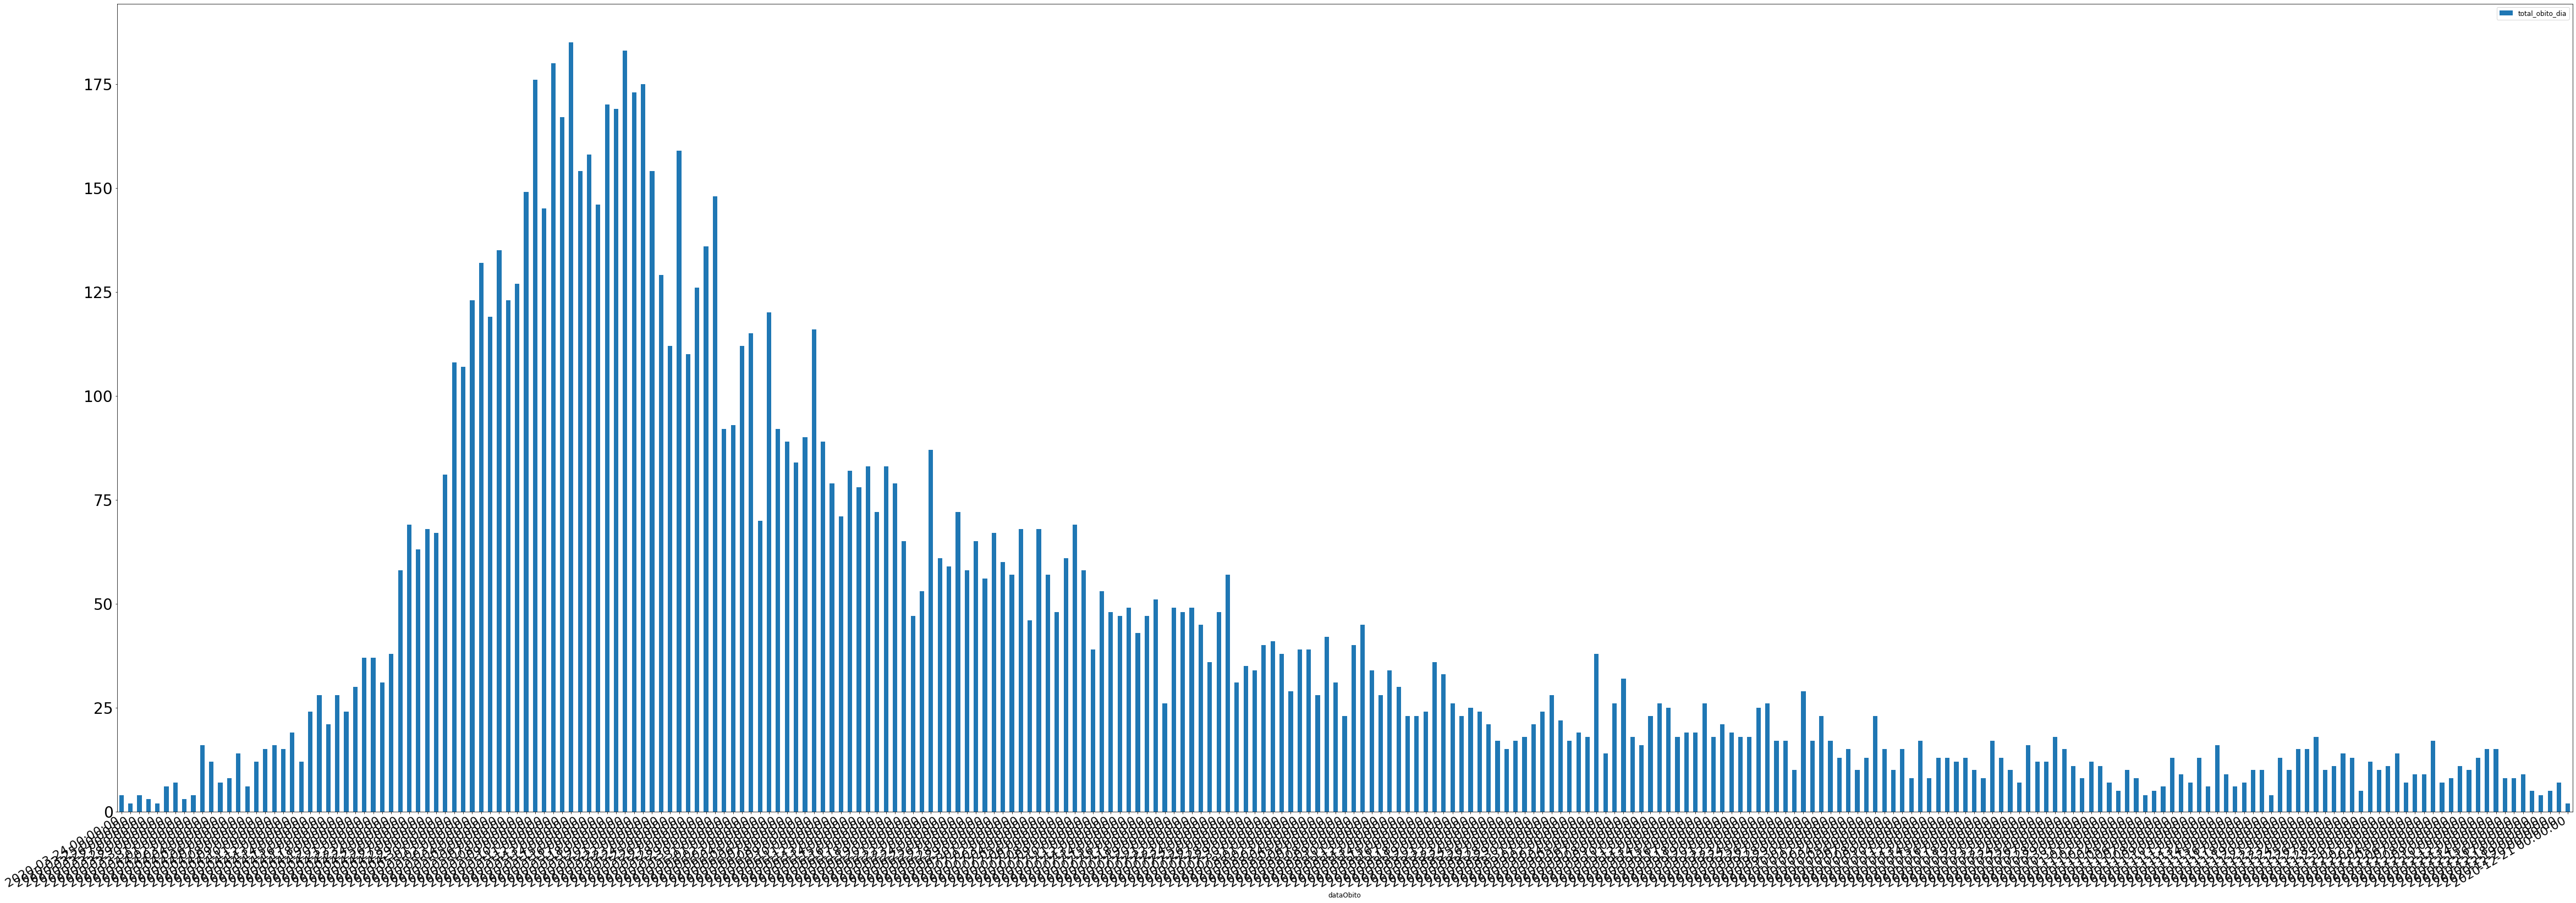

In [225]:
import matplotlib.ticker as ticker

df_grafico_obito.sort_values('dataObito', ascending= True, inplace=True)

ax = df_grafico_obito.plot(x ='dataObito', y='total_obito_dia', kind = 'bar' , figsize=(80, 30))
#ticklabels[::4] = [item.strftime('%b %d') for item in df_grafico_obito.dataObito[::4]]

#ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=22)
plt.yticks(fontsize=28)
plt.show()




In [226]:
group_obitos_by_day = df_obitos['qtObito'].groupby(df['dataObito']).sum()

In [227]:
group_obitos_by_day

dataObito
2020-03-24    4
2020-03-25    2
2020-03-26    4
2020-03-27    3
2020-03-28    2
             ..
2020-12-17    5
2020-12-18    4
2020-12-19    5
2020-12-20    7
2020-12-21    2
Name: qtObito, Length: 273, dtype: int64

In [228]:
type(group_obitos_by_day)

pandas.core.series.Series

In [229]:
# Criar campo para óbitos totais de um mesmo dia
df_obitos['qtdeObitoAcumuladoPorDia'] = df_obitos['qtObito'].groupby(df['dataObito']).transform('sum')
#df_obitos.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [230]:
df_obitos['qt_obito_dia'] = df_obitos['qtObito'].groupby(df['dataObito']).transform('sum')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [231]:
df_obitos.loc['qt_obito_dia_2'] = df_obitos['qtObito'].groupby(df['dataObito']).transform('sum')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [232]:
df_obitos.sort_values(by='dataObito')

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeObitoAcumuladoPorDia,qt_obito_dia
970157,e00481f300496b7c996f781c5b9edc0f,NaN,202017481,3.158525e+11,NaN,Positivo,Confirmação Laboratorial,Óbito,NaN,False,BRASIL,CE,230440.0,FORTALEZA,COCO,NaN,FEMININO,84.0,80 ou mais,1936-02-26,2020-03-24,2020-03-21,NaT,2020-03-24 00:00:00,2020-03-24 00:00:00,Positivo,GAL,Positivo,NaN,NaN,NaN,Óbito,2020-03-24 00:00:00.000,Não,Sim,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,RT-PCR,2.022130e+11,Não Informado,2020-05-20 17:24:35.783,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,RT-PCR,True,2020-03-24,Confirmado,HOSPITAL SAO MATEUS,NaN,NaN,1.0,1.0,0.0,4.0,4.0
970694,82563a758fad9d2126eabf2d356277d6,NaN,202017974,3.158514e+11,NaN,NaN,NaN,NaN,NaN,False,BRASIL,CE,230440.0,FORTALEZA,JOVITA FEITOSA,NaN,FEMININO,97.0,80 ou mais,1923-02-03,2020-03-24,2020-03-21,NaT,2020-03-24 00:00:00,2020-04-28 00:00:00,Positivo,GAL,Positivo,2020-03-23 00:00:00.000,2020-03-23 00:00:00.000,NaN,Óbito,2020-03-24 00:00:00.000,NaN,Sim,NaN,NaN,NaN,NaN,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.022200e+11,Não Informado,2020-05-20 17:30:03.817,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,NaN,True,2020-03-24,Confirmado,HOSPITAL GENESIS,NaN,NaN,1.0,1.0,0.0,4.0,4.0
970693,82563a758fad9d2126eabf2d356277d6,NaN,202017950,3.158514e+11,NaN,Positivo,Confirmação Laboratorial,NaN,NaN,False,BRASIL,CE,230440.0,FORTALEZA,JOVITA FEITOSA,NaN,FEMININO,97.0,80 ou mais,1923-02-03,2020-03-24,2020-03-21,NaT,2020-03-24 00:00:00,2020-04-28 00:00:00,Positivo,GAL,Positivo,2020-03-23 00:00:00.000,2020-03-23 00:00:00.000,NaN,Óbito,2020-03-24 00:00:00.000,NaN,Sim,NaN,NaN,NaN,NaN,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.022200e+11,Não Informado,2020-05-20 17:30:03.817,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,RT-PCR,True,2020-03-24,Confirmado,HOSPITAL GENESIS,NaN,NaN,1.0,1.0,0.0,4.0,4.0
306032,ed2d67f326d60173a53ee585606b5910,NaN,202016773,3.158931e+11,NaN,Positivo,Confirmação Laboratorial,Óbito,NaN,False,BRASIL,CE,230440.0,FORTALEZA,FATIMA,NaN,FEMININO,41.0,40 a 44 anos,1979-02-04,2020-03-23,2020-03-18,NaT,2020-03-23 00:00:00,2020-03-23 00:00:00,Positivo,GAL,Positivo,2020-03-23 00:00:00.000,NaN,NaN,Óbito,2020-03-24 00:00:00.000,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,NaN,NaN,RT-PCR,2.001430e+11,Não Informado,2020-05-20 17:24:52.363,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,RT-PCR,True,2020-03-24,Confirmado,HOSPITAL REGIONAL UNIMED,PRIVADA,40-44,1.0,1.0,0.0,4.0,4.0
692673,b00c718834fa5608b8b2291a3853b7cc,NaN,NaN,3.158619e+11,NaN,NaN,NaN,NaN,NaN,NaN,BRASIL,CE,230440.0,FORTALEZA,PICI,NaN,MASCULINO,66.0,65 a 69 anos,1954-04-11,2020-03-28,2020-03-21,2020-03-25,2020-03-25 00:00:00,2020-03-27 17:17:37,Positivo,GAL,Positivo,NaN,NaN,NaN,Óbito,2020-03-25 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.001190e+11,Não Informado,2020-05-20 17:24:38.113,NaN,N

In [233]:
df_obitos.head(3)

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeObitoAcumuladoPorDia,qt_obito_dia
11478,c7a534be5edb22fccdc845c2a6a8085a,NaN,232001023852,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,CE,230440.0,FORTALEZA,AEROLANDIA,NaN,MASCULINO,47.0,45 a 49 anos,1973-07-08,2020-05-12,2020-05-04,NaT,2020-05-11 06:00:00,2020-05-11,Positivo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.022290e+11,Parda,2020-06-01 09:58:51.613,NaN,FORTALEZA,NaN,NaN,NaN,NaN,True,2020-05-17,Confirmado,HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STU...,PÚBLICA,45-49,1.0,1.0,0.0,170.0,170.0
22759,3b9a0ede6b82f292b5d929a545f8fd3d,NaN,232005151576,NaN,NaN,Positivo,Confirmado Laboratorial,Óbito,NaN,False,NaN,CE,230690.0,JAGUARIBE,ZONA RURAL,NaN,MASCULINO,86.0,80 ou mais,1933-12-05,2020-06-21,2020-06-11,NaT,2020-06-21 03:00:00,2020-06-21,Positivo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.010020e+11,Parda,2020-07-04 10:24:12.563,NaN,JAGUARIBE,NaN,NaN,NaN,RT-PCR,True,2020-07-02,Confirmado,HOSPITAL SAO RAIMUNDO,PÚBLICA,NaN,1.0,1.0,0.0,68.0,68.0
26202,008a39c0fcc0bad0ddfe29eec7ae1fee,NaN,232005701456,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230765.0,MARACANAU,SIQUEIRA,NaN,MASCULINO,89.0,80 ou mais,1931-01-27,2020-04-28,2020-04-24,NaT,2020-04-28 06:00:00,2020-05-08,Positivo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.003180e+11,Parda,2020-07-21 13:30:14.527,NaN,MARACANAU,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,True,2020-05-02,Confirmado,UPA 24 HORA MARACANAU,PÚBLICA,NaN,1.0,1.0,0.0,123.0,123.0


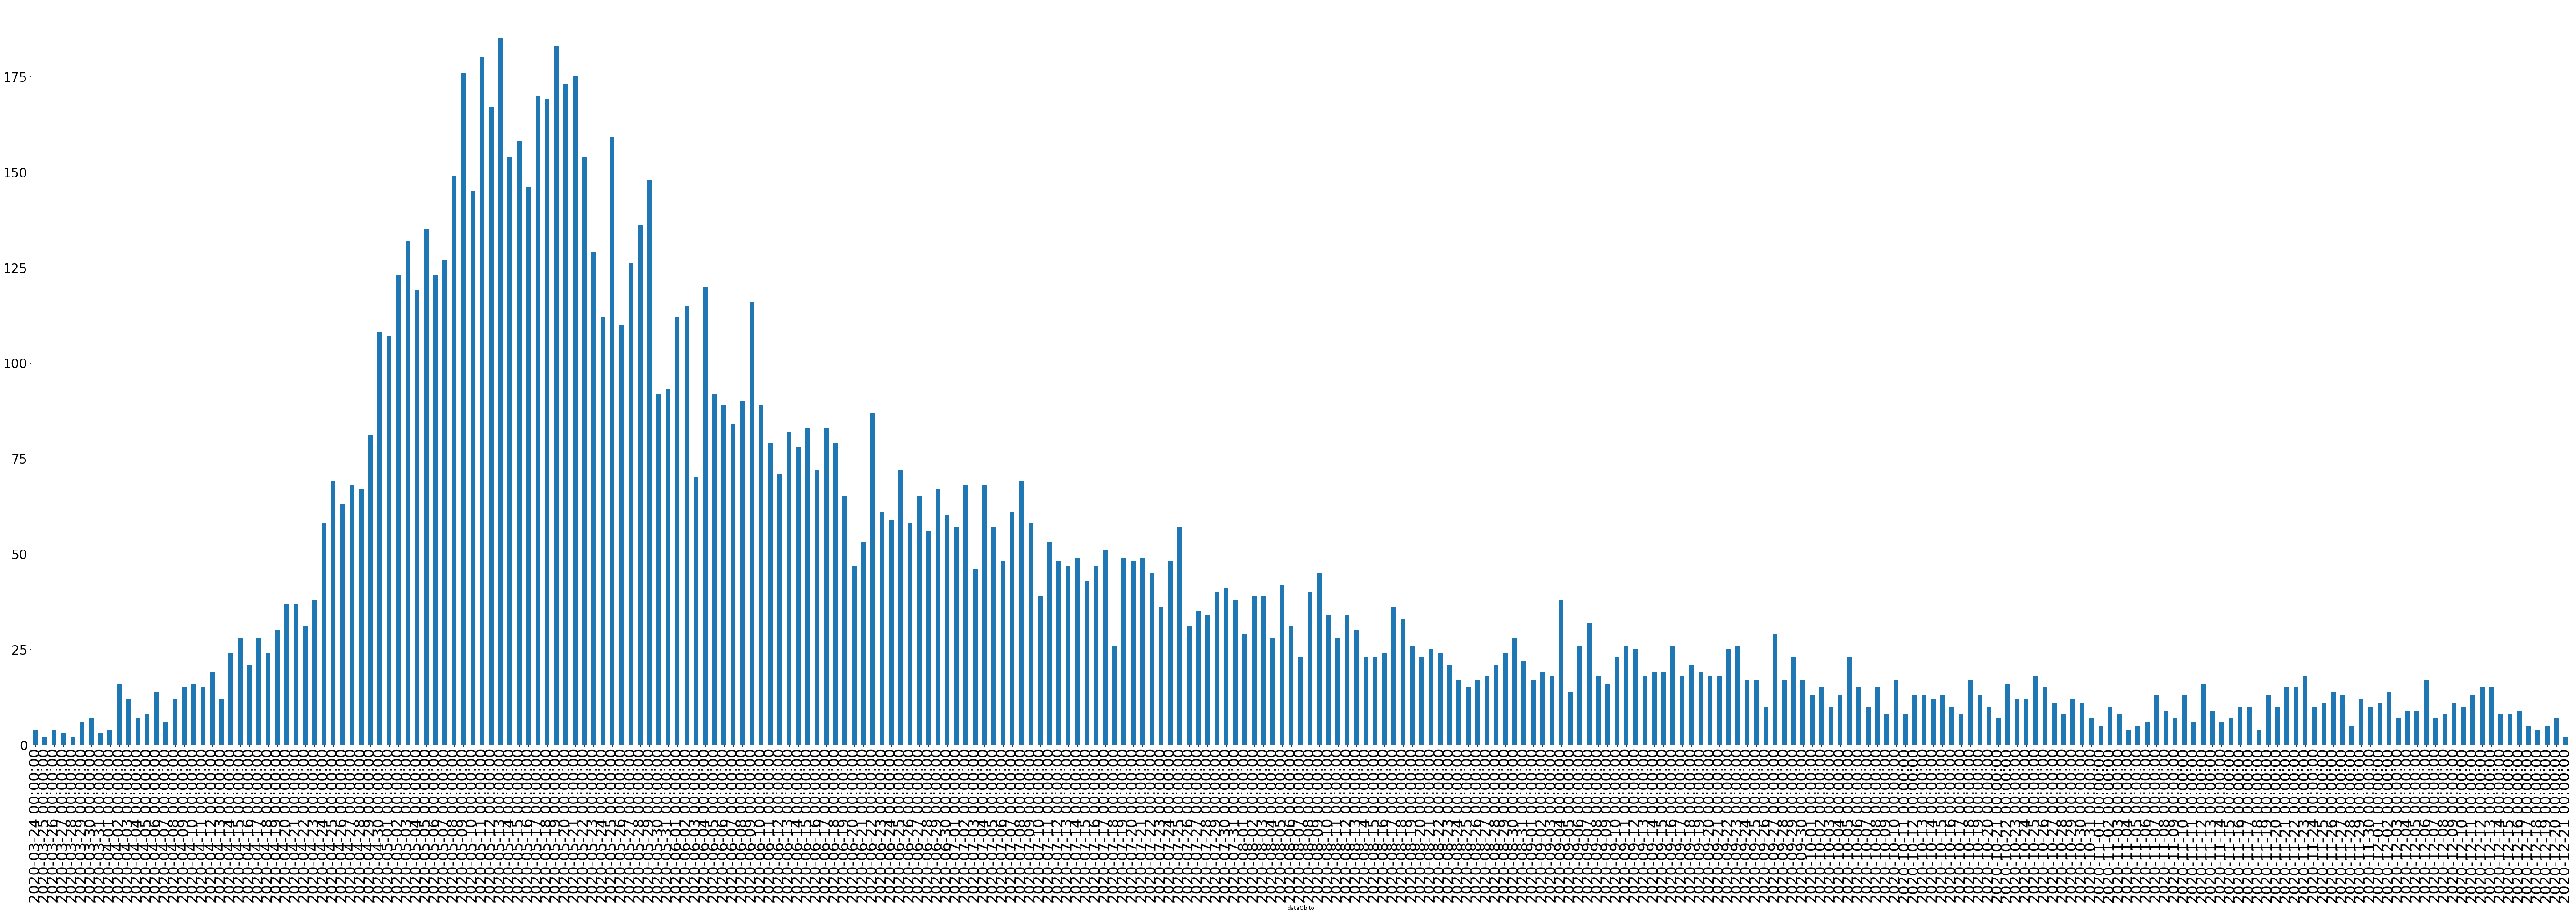

In [234]:
week_groups = df_obitos.groupby([df_obitos['dataObito']])['qtObito'].sum()
week_groups.plot(kind='bar',figsize=(100,30),legend=None)

plt.xticks(fontsize=32)

plt.yticks(fontsize=28)

plt.show()

# ver https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html

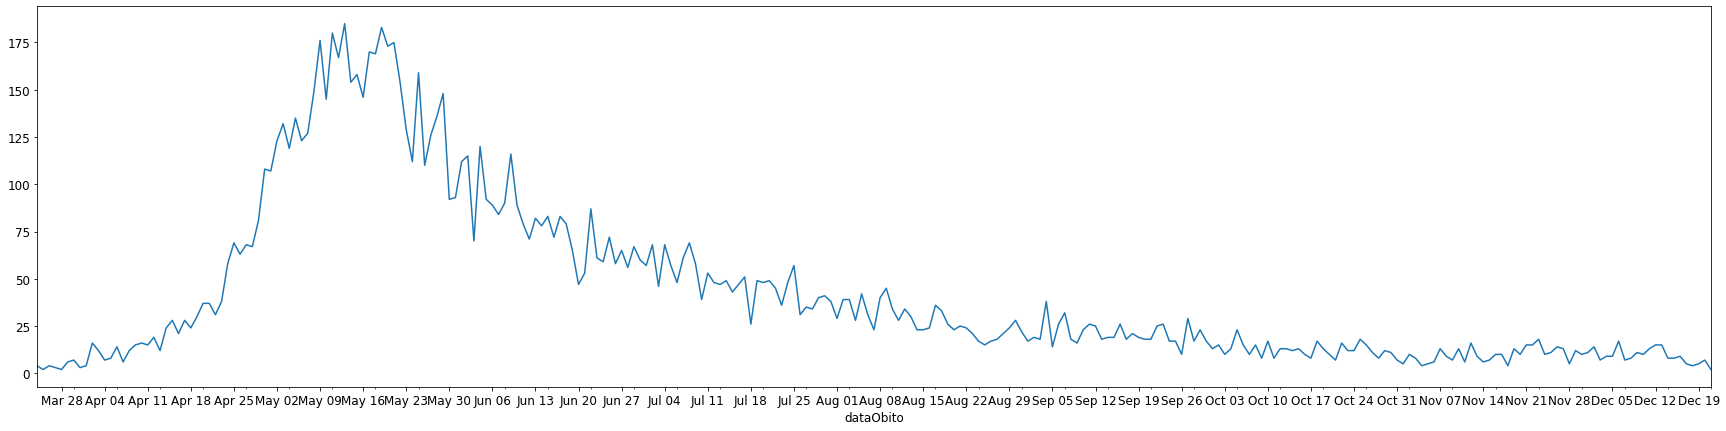

In [235]:
fig, ax = plt.subplots(figsize=(30,7))
week_groups.plot(ax=ax)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [236]:
# validando o gráfico acima
condicao = df_obitos['dataObito'] == '2020-04-01'
df_obitos[condicao]

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeObitoAcumuladoPorDia,qt_obito_dia
697609,813b172d7e33b0dfc7d3a21d1514cd16,NaN,NaN,3.160028e+11,NaN,NaN,NaN,NaN,NaN,NaN,BRASIL,CE,230440.0,FORTALEZA,BOM FUTURO,NaN,MASCULINO,92.0,80 ou mais,1928-06-23,2020-03-28,2020-03-23,2020-03-28,2020-03-23 03:00:00,2020-04-16 11:02:16,Positivo,GAL,Positivo,2020-03-27 00:00:00.000,NaN,NaN,Óbito,2020-04-01 00:00:00.000,Não,Sim,NaN,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,RT-PCR,NaN,Não Informado,2020-09-19 12:06:02.847,NaN,NaN,NaN,SRAG por COVID-19,NaN,NaN,True,2020-04-01,Confirmado,HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STU...,PÚBLICA,NaN,1.0,1.0,0.0,4.0,4.0
719248,9f62c6dfde5ca75c3b6d8ddc6a210e8a,NaN,202017700,3.158525e+11,NaN,Positivo,Confirmação Laboratorial,Óbito,NaN,False,BRASIL,CE,230440.0,FORTALEZA,MEIRELES,NaN,FEMININO,86.0,80 ou mais,1934-03-25,2020-03-24,2020-03-10,NaT,2020-03-24 00:00:00,2020-03-24 00:00:00,Positivo,GAL,Positivo,2020-03-24 00:00:00.000,NaN,NaN,Óbito,2020-04-01 00:00:00.000,Não,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,NaN,NaN,RT-PCR,2.022210e+11,Parda,2020-05-20 17:24:49.457,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,RT-PCR,True,2020-04-01,Confirmado,HOSPITAL CURA DARS,NaN,NaN,1.0,1.0,0.0,4.0,4.0
971578,119a6e1e477f25151fc85264b0e8fa20,NaN,232000048146,NaN,NaN,Negativo,Descartado,Ignorado,NaN,False,NaN,CE,230440.0,FORTALEZA,CARLITO PAMPLONA,NaN,FEMININO,52.0,50 a 54 anos,1968-05-26,2020-03-31,2020-03-16,NaT,2020-03-31 03:00:00,2020-03-31 00:00:00,Positivo,LACEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.000118e+12,Não Informado,2020-06-10 10:28:13.193,NaN,FORTALEZA,NaN,NaN,NaN,RT-PCR,True,2020-04-01,Confirmado,HGF HOSPITAL GERAL DE FORTALEZA,PÚBLICA,50-54,1.0,1.0,0.0,4.0,4.0
972421,df8736841bfcebff379e269cf0212c31,NaN,232000012402,3.159361e+11,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,BRASIL,CE,230440.0,FORTALEZA,JOCKEY CLUB,NaN,FEMININO,76.0,75 a 79 anos,1944-06-09,2020-03-27,2020-03-17,NaT,2020-03-27 03:00:00,2020-03-27 00:00:00,Positivo,GAL,Em Análise,2020-03-26 00:00:00.000,NaN,NaN,Óbito,2020-04-01 00:00:00.000,Não,Não,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,RT-PCR,2.001560e+11,Parda,2020-05-20 17:24:57.487,NaN,FORTALEZA,NaN,SRAG por COVID-19,NaN,RT-PCR,True,2020-04-01,Confirmado,UNIDADE PRONTO ATENDIMENTO AUTRAN NUNES,PÚBLICA,75-79,1.0,1.0,0.0,4.0,4.0


In [237]:
# Criar campo para casos confirmados sem óbitos totais de um mesmo dia
df_confirmados['qtdeCasoAcumuladoPorDia'] = df_confirmados['qtCasoConfirmadoSemObito'].groupby(df['dataResultadoExame']).transform('sum')
df_confirmados.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeCasoAcumuladoPorDia
14,7d7f8acc41c36e346802da6a0fd2a179,NaN,232002501916,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,CE,230840.0,MISSAO VELHA,CENTRO,NaN,FEMININO,2.0,00 a 04 anos,2017-12-11,2020-06-03,2020-05-13,NaT,2020-06-03,2020-06-03,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Branca,NaT,NaN,MISSAO VELHA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,0-4,0,1,1,2430.0
16,832b20575eaccfeff07f834becf4dafa,NaN,232001170268,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,CE,230020.0,ACARAU,CAUASSU,NaN,MASCULINO,51.0,50 a 54 anos,1968-12-27,2020-05-11,2020-05-01,NaT,2020-05-11,2020-05-11,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Parda,NaT,2527952,ACARAU,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,50-54,0,1,1,1715.0
25,e716b4e999f1b0ffcd7bf00b12f662d0,NaN,232002711135,NaN,NaN,Positivo,NaN,NaN,NaN,False,NaN,RIO GRANDE DO NORTE,NaN,SANTA CRUZ,CENTRO,NaN,MASCULINO,43.0,40 a 44 anos,1976-11-13,2020-06-05,2020-05-22,NaT,2020-06-01,2020-06-01,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Amarela,NaT,2527677,JAGUARIBARA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,40-44,0,1,1,2785.0


In [238]:
df_confirmados['MA'] = df_confirmados.qtCasoConfirmadoSemObito.rolling(window=7).mean()
df_confirmados.sort_values(by='dataResultadoExame').head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeCasoAcumuladoPorDia,MA
26243,0f4ffbb7d7761d3ffb606624d28797cc,NaN,232002324896,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,231340.0,TIANGUA,FRECHEIRAS DE CIMA,NaN,FEMININO,27.0,25 a 29 anos,1992-09-18,2020-06-02,2020-04-29,NaT,2020-01-01,2020-01-01,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Branca,NaT,6364284,TIANGUA,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,25-29,0,1,1,2.0,1.0
1083838,fc5f0e8b539a6b46d02d53bf3e01fb27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CE,230440.0,FORTALEZA,NaN,NaN,FEMININO,35.0,35 a 39 anos,1985-01-30,NaT,NaT,NaT,2020-09-28,2020-01-01,Positivo,HIPOLITO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quimioluminescência,NaN,Não Informado,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,35-39,0,1,1,2.0,1.0
884872,e47878d0bc8d3dda609cd7794896e500,NaN,232002648902,NaN,NaN,Positivo,Confirmado Laboratorial,Cura,NaN,False,NaN,CE,230535.0,ICAPUI,IBICUITABA,NaN,FEMININO,51.0,50 a 54 anos,1969-06-12,2020-06-02,2020-05-27,NaT,2020-01-02,2020-01-02,Positivo,ESUS (TESTE RÁPIDO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,NaN,Branca,NaT,4011287,ICAPUI,NaN,NaN,NaN,TESTE RÁPIDO - ANTICORPO,NaN,NaT,NaN,NaN,NaN,50-54,0,1,1,1.0,1.0


In [239]:
df_confirmados.sort_values(by='dataResultadoExame').tail(3)

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeCasoAcumuladoPorDia,MA
1488142,d5b91c585ffaaf76d72b105c096a94b6,NaN,232005831533,NaN,NaN,NaN,Confirmado Laboratorial,Em tratamento domiciliar,NaN,False,NaN,CE,230440.0,FORTALEZA,JARDIM GUANABARA,NaN,MASCULINO,49.0,45 a 49 anos,1971-09-14,2020-06-24,2020-04-26,NaT,NaT,NaT,Positivo,ESUS (RT-PCR),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,NaN,Parda,NaT,2497654,FORTALEZA,NaN,NaN,NaN,RT-PCR,NaN,NaT,NaN,NaN,NaN,45-49,0,1,1,NaN,1.0
1488168,2805e30f311acef2dae84d25132ea28e,NaN,232009217316,NaN,NaN,NaN,Confirmado Clínico-Epidemiológico,Cura,NaN,False,NaN,CE,230015.0,ACARAPE,SAO BENEDITO,NaN,FEMININO,29.0,25 a 29 anos,1991-04-15,2020-06-23,2020-06-07,NaT,NaT,NaT,Positivo,ESUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado Clínico-Epidemiológico,NaN,Parda,NaT,2664232,ACARAPE,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,25-29,0,1,1,NaN,1.0
1488237,982eb65b3d0d572945eff814e5ba20ef,NaN,232001134949,NaN,NaN,NaN,Confirmado Clínico-Epidemiológico,Cura,4221 - Recepcionista,True,NaN,CE,231020.0,PARACURU,CENTRO,NaN,FEMININO,24.0,20 a 24 anos,1996-08-19,2020-05-13,2020-05-01,NaT,NaT,NaT,Positivo,ESUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado Clínico-Epidemiológico,NaN,Não Informado,NaT,231025,PARAIPABA,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,20-24,0,1,1,NaN,1.0


In [240]:
 # Método 01 para contagem de óbitos por dia
df_new = (pd.to_datetime(df_obitos['dataObito'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('data_obito')
       .reset_index(name='count'))
print (df_new)

    data_obito  count
0   2020-05-13    185
1   2020-05-19    183
2   2020-05-11    180
3   2020-05-09    176
4   2020-05-21    175
..         ...    ...
268 2020-03-27      3
269 2020-03-31      3
270 2020-03-25      2
271 2020-03-28      2
272 2020-12-21      2

[273 rows x 2 columns]


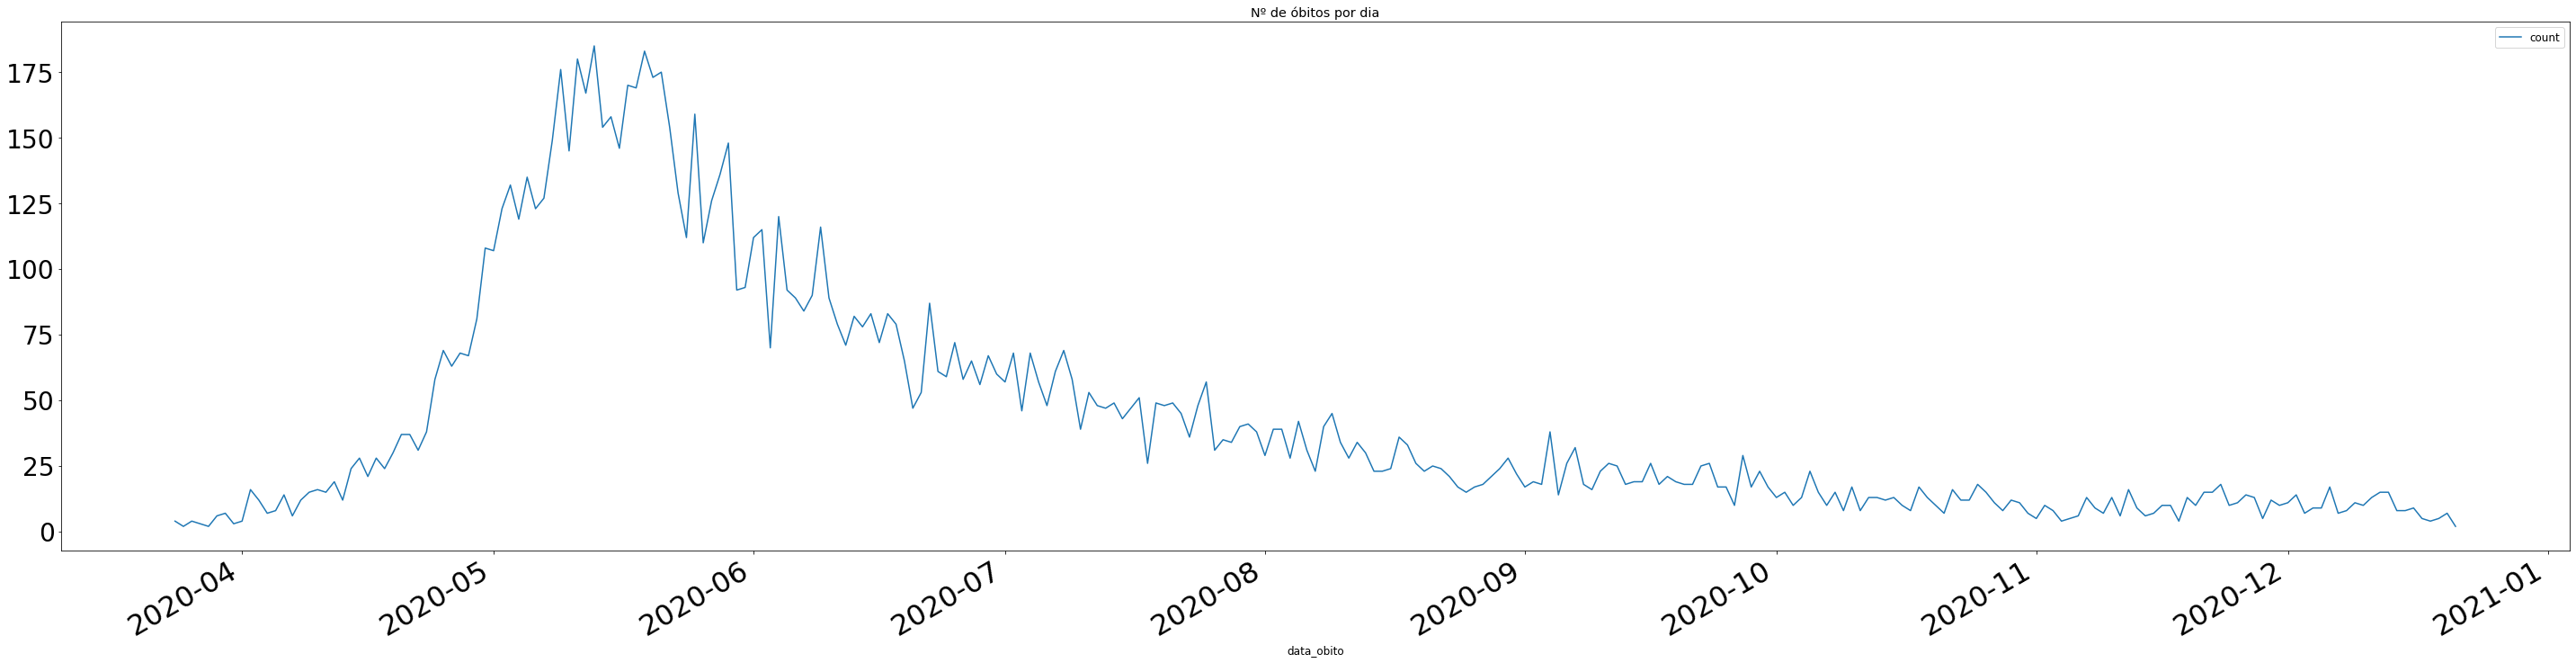

In [241]:
df_new.plot(x ='data_obito', y='count', kind = 'line', figsize= (50,12) , title ='Nº de óbitos por dia')
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)
plt.xticks(fontsize=32)
plt.yticks(fontsize=28)
plt.show()

**Fazer o acumulado por dia no df_new**

In [242]:
## TODO

***Gerar novo dataset de óbitos somente para plotagem***

In [243]:
 # Método 02 para contagem de óbitos por dia
# um novo dataset para plotagem
new_df_obit = df_obitos.groupby(['dataObito'])['qtObito'].sum().to_frame('total').reset_index()
new_df_obit

,dataObito,total
0,2020-03-24,4.0
1,2020-03-25,2.0
2,2020-03-26,4.0
3,2020-03-27,3.0
4,2020-03-28,2.0
...,...,...
268,2020-12-17,5.0
269,2020-12-18,4.0
270,2020-12-19,5.0
271,2020-12-20,7.0


In [244]:
# Teste
df_new[df_new['data_obito'] == '2020-09-10']

,data_obito,count
140,2020-09-10,23


In [245]:
new_df_obit['totalAcumulado'] = new_df_obit['total'].cumsum()
new_df_obit

,dataObito,total,totalAcumulado
0,2020-03-24,4.0,4.0
1,2020-03-25,2.0,6.0
2,2020-03-26,4.0,10.0
3,2020-03-27,3.0,13.0
4,2020-03-28,2.0,15.0
...,...,...,...
268,2020-12-17,5.0,11640.0
269,2020-12-18,4.0,11644.0
270,2020-12-19,5.0,11649.0
271,2020-12-20,7.0,11656.0


***Gerar novo dataset de casos confirmados somente para plotagem***

In [246]:
new_df_casos_confirm = df_confirmados.groupby(['dataResultadoExame'])['qtCasoConfirmadoSemObito'].sum().to_frame('total').reset_index()
new_df_casos_confirm.head

<bound method NDFrame.head of        dataResultadoExame  total
0     2020-01-01 00:00:00      2
1     2020-01-02 00:00:00      1
2     2020-01-07 00:00:00      1
3     2020-01-11 00:00:00      2
4     2020-01-16 00:00:00      1
...                   ...    ...
82939 2020-12-21 21:54:57      2
82940 2020-12-21 21:55:40      2
82941 2020-12-21 21:59:57      1
82942 2020-12-21 21:59:58      2
82943 2020-12-21 22:02:48      1

[82944 rows x 2 columns]>

In [247]:
new_df_casos_confirm['totalAcumulado'] = new_df_casos_confirm['total'].cumsum()
new_df_casos_confirm

,dataResultadoExame,total,totalAcumulado
0,2020-01-01 00:00:00,2,2
1,2020-01-02 00:00:00,1,3
2,2020-01-07 00:00:00,1,4
3,2020-01-11 00:00:00,2,6
4,2020-01-16 00:00:00,1,7
...,...,...,...
82939,2020-12-21 21:54:57,2,395899
82940,2020-12-21 21:55:40,2,395901
82941,2020-12-21 21:59:57,1,395902
82942,2020-12-21 21:59:58,2,395904


**Gráfico 01 - Curva acumulado de óbitos por período**



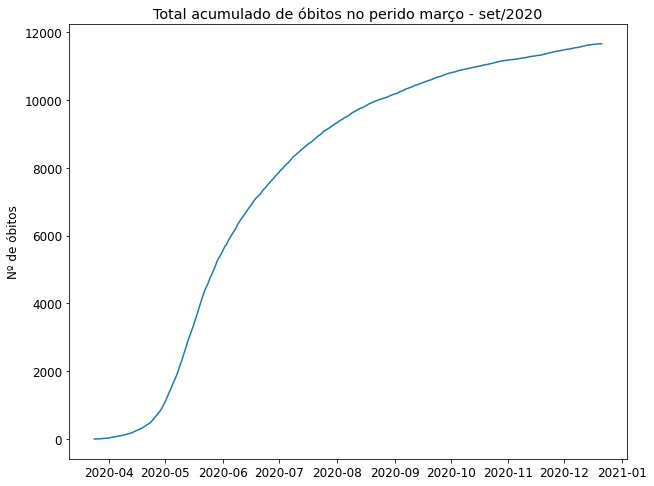

In [248]:
plt.plot( new_df_obit['dataObito'], new_df_obit['totalAcumulado'] )
plt.title('Total acumulado de óbitos no perido março - set/2020')
matplotlib.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (10,8)
plt.ylabel('Nº de óbitos');
plt.show()

**Gráfico 02 - Curva acumulado de casos confirmados acumulados  por período**

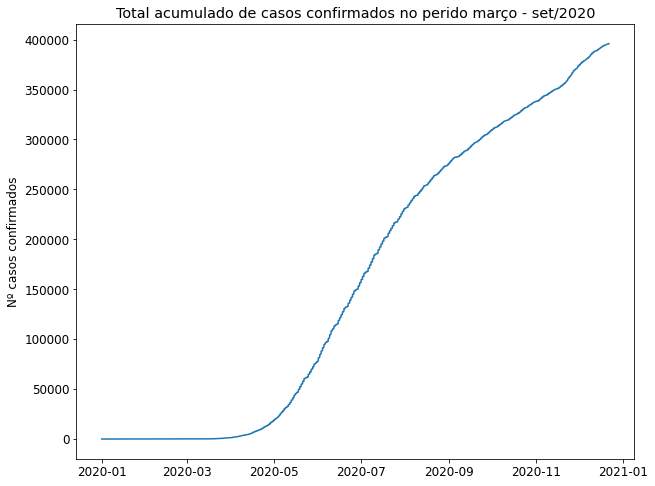

In [249]:
plt.plot( new_df_casos_confirm['dataResultadoExame'], new_df_casos_confirm['totalAcumulado'] )
plt.title('Total acumulado de casos confirmados no perido março - set/2020')
matplotlib.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (10,8)
plt.ylabel('Nº casos confirmados');
plt.show()

In [250]:
group_obito_data = df_obitos.groupby('dataObito').qtObito.sum()
group_obito_data

dataObito
2020-03-24    4.0
2020-03-25    2.0
2020-03-26    4.0
2020-03-27    3.0
2020-03-28    2.0
             ... 
2020-12-17    5.0
2020-12-18    4.0
2020-12-19    5.0
2020-12-20    7.0
2020-12-21    2.0
Name: qtObito, Length: 273, dtype: float64

In [251]:
# Cálculo para média móvel com janela de 7 dias
df_obitos['mediaMovelObito'] = df_obitos.qtObito.rolling(window=7).mean()

df_confirmados['mediaMovelCasos'] = df_confirmados.qtCasoConfirmadoSemObito.rolling(window=7).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Gráfico 03 - Total de óbitos por dia no período Março - Setembro 2020 (Resumido )**

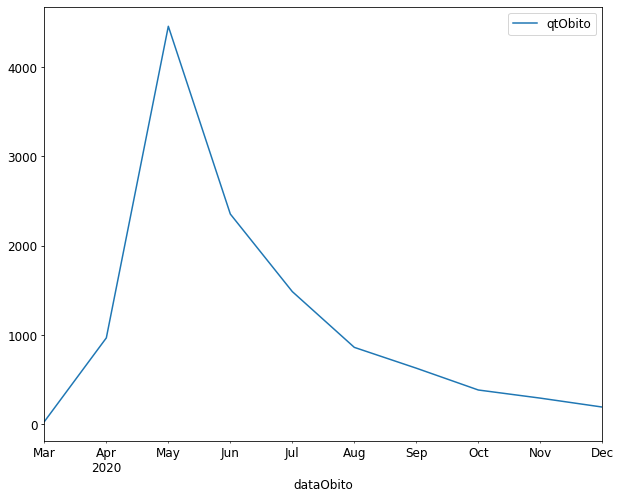

In [252]:
  # agrupar por mes a qtde de obitos e plotar
df_obitos.groupby(pd.Grouper(key='dataObito',freq='M')).agg({'qtObito':'sum'}).plot(figsize=(10, 8))

In [253]:
group_acumulado_ob_dia = df_obitos.groupby('dataObito')
group_acumulado_ob_dia['dataObito'].count()

dataObito
2020-03-24    4
2020-03-25    2
2020-03-26    4
2020-03-27    3
2020-03-28    2
             ..
2020-12-17    5
2020-12-18    4
2020-12-19    5
2020-12-20    7
2020-12-21    2
Name: dataObito, Length: 273, dtype: int64

**Gráfico 04 - Total de óbitos por dia no período Março - Setembro 2020 (Detalhado)**

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 10 Text major ticklabel objects>)

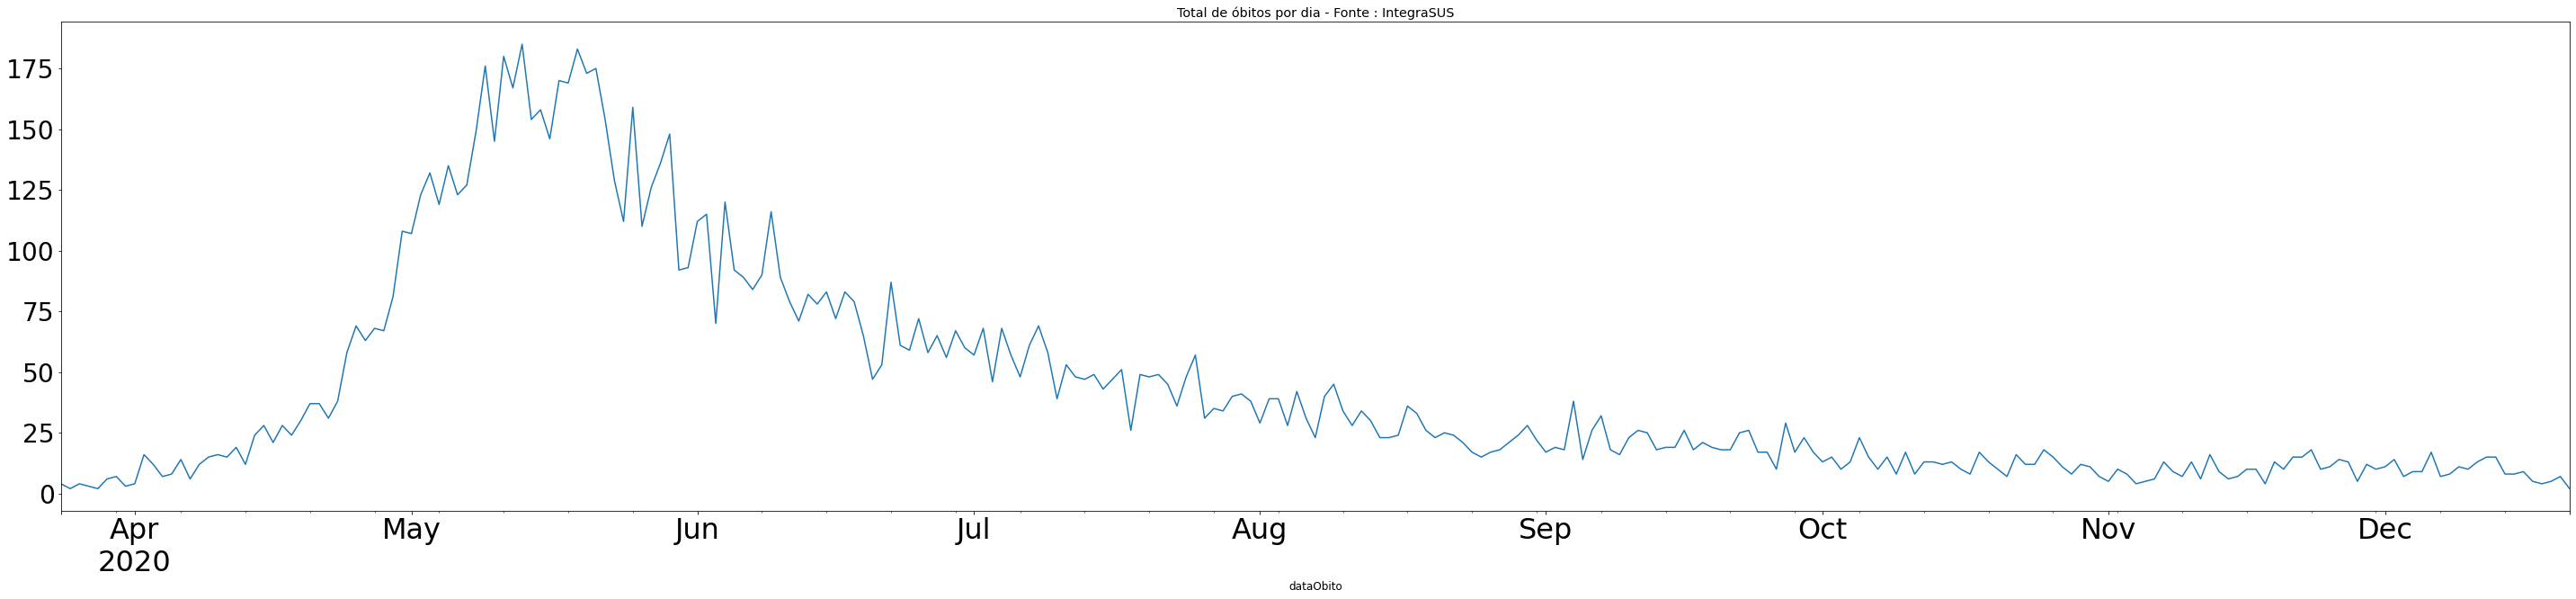

In [254]:
gr_grafico_acumulado_ob_dia = group_acumulado_ob_dia['dataObito'].count()
gr_grafico_acumulado_ob_dia.plot( figsize=(50,10), title = 'Total de óbitos por dia - Fonte : IntegraSUS')
plt.xticks(fontsize=32)
plt.yticks(fontsize=28)

**Gráfico 04 - Total de novos casos por dia no período Março - Setembro 2020 (Resumido)**

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text major ticklabel objects>)

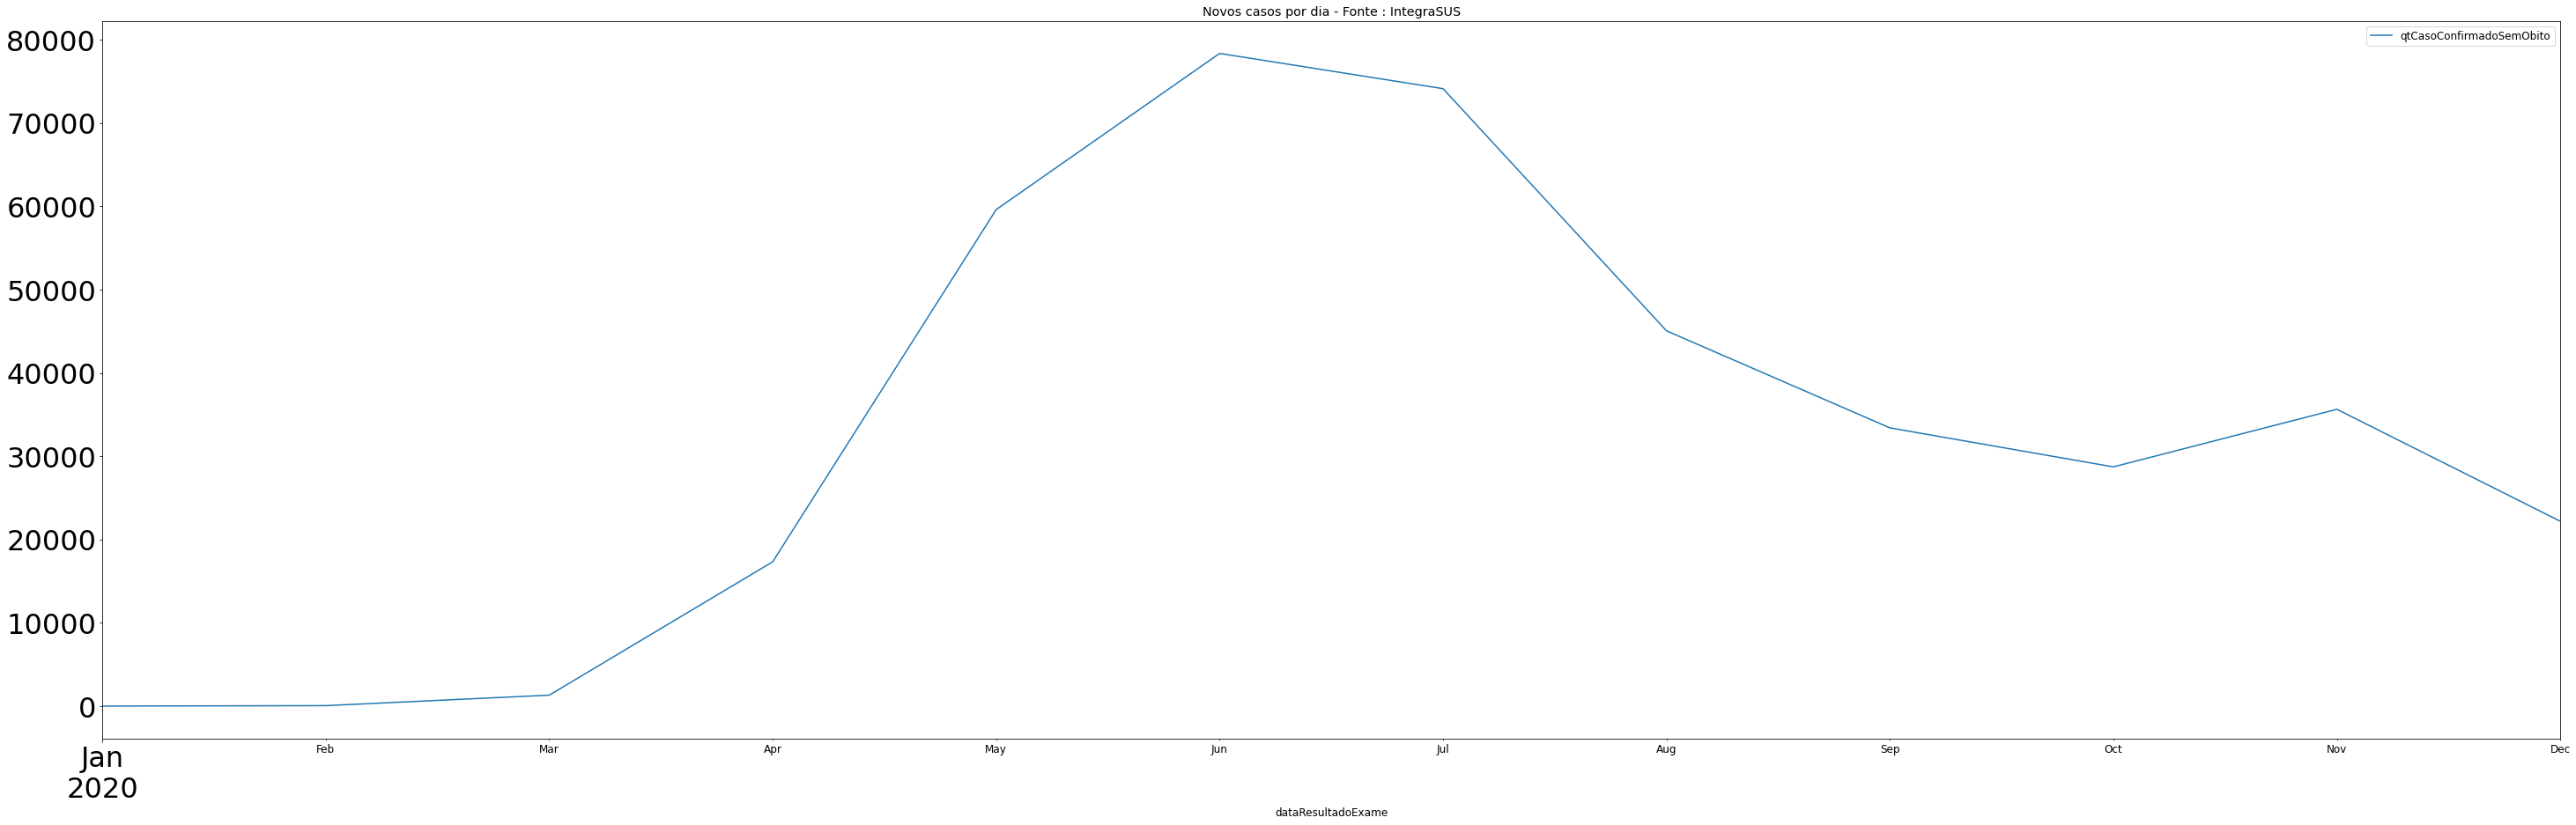

In [255]:
  # agrupar por mes a qtde de casos confirmados SEM óbito e plotar
df_confirmados.groupby(pd.Grouper(key='dataResultadoExame',freq='M')).agg({'qtCasoConfirmadoSemObito':'sum'}).plot(figsize=(50, 15) ,title = 'Novos casos por dia - Fonte : IntegraSUS')
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

**Preparar para plotagem somente de casos confirmados**

In [256]:
group_confirmados = df_confirmados.groupby(by=df_confirmados['dataResultadoExame'].dt.date).count()
df_confir_graf = group_confirmados['dataResultadoExame']

**Gráfico 04 - Total de novos por dia no período Março - Setembro 2020 Histogram**

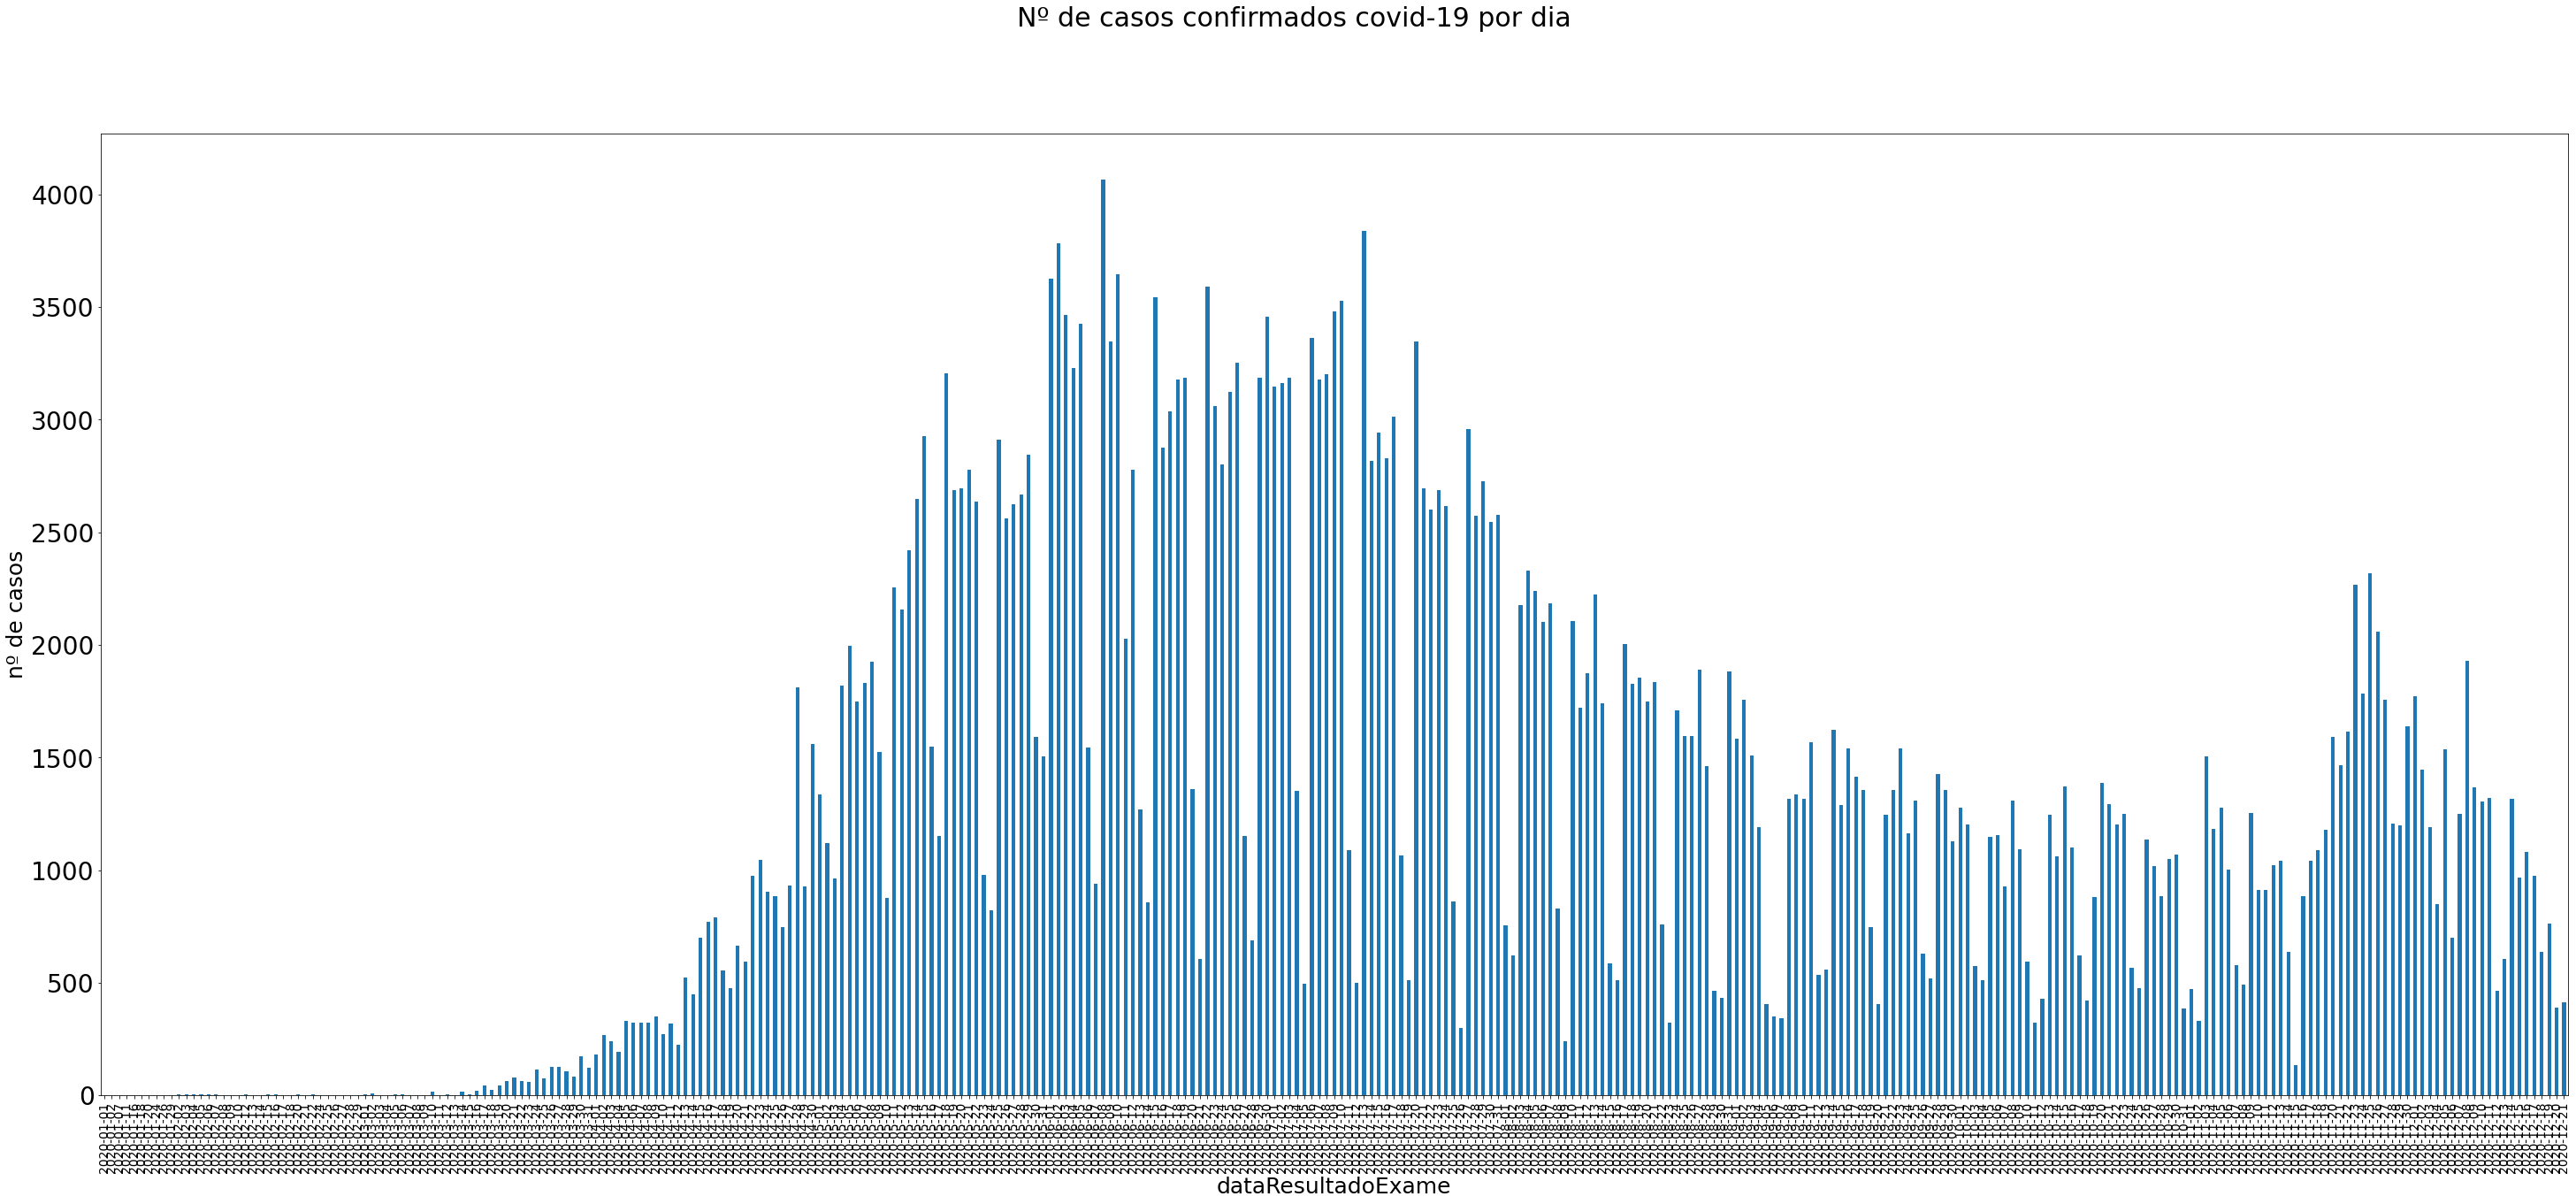

In [257]:
# Plotagem fica muito grande, tirar pela média movel de novos casos
plt.xlabel('Data resultado do exame', fontsize=25) 
plt.ylabel('nº de casos', fontsize=25)

plt.suptitle('Nº de casos confirmados covid-19 por dia', fontsize=30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=28)

df_confir_graf.plot(figsize=(50, 20), kind='bar')

**Preparar para plotagem somente dos óbitos**


In [258]:
group_obito = df_obitos.groupby(by=df_obitos['dataObito'].dt.date).count()
# group_obito.

**Gráfico 05 - Total de novos óbitos por dia no período Março - Setembro 2020 (Histogram)**

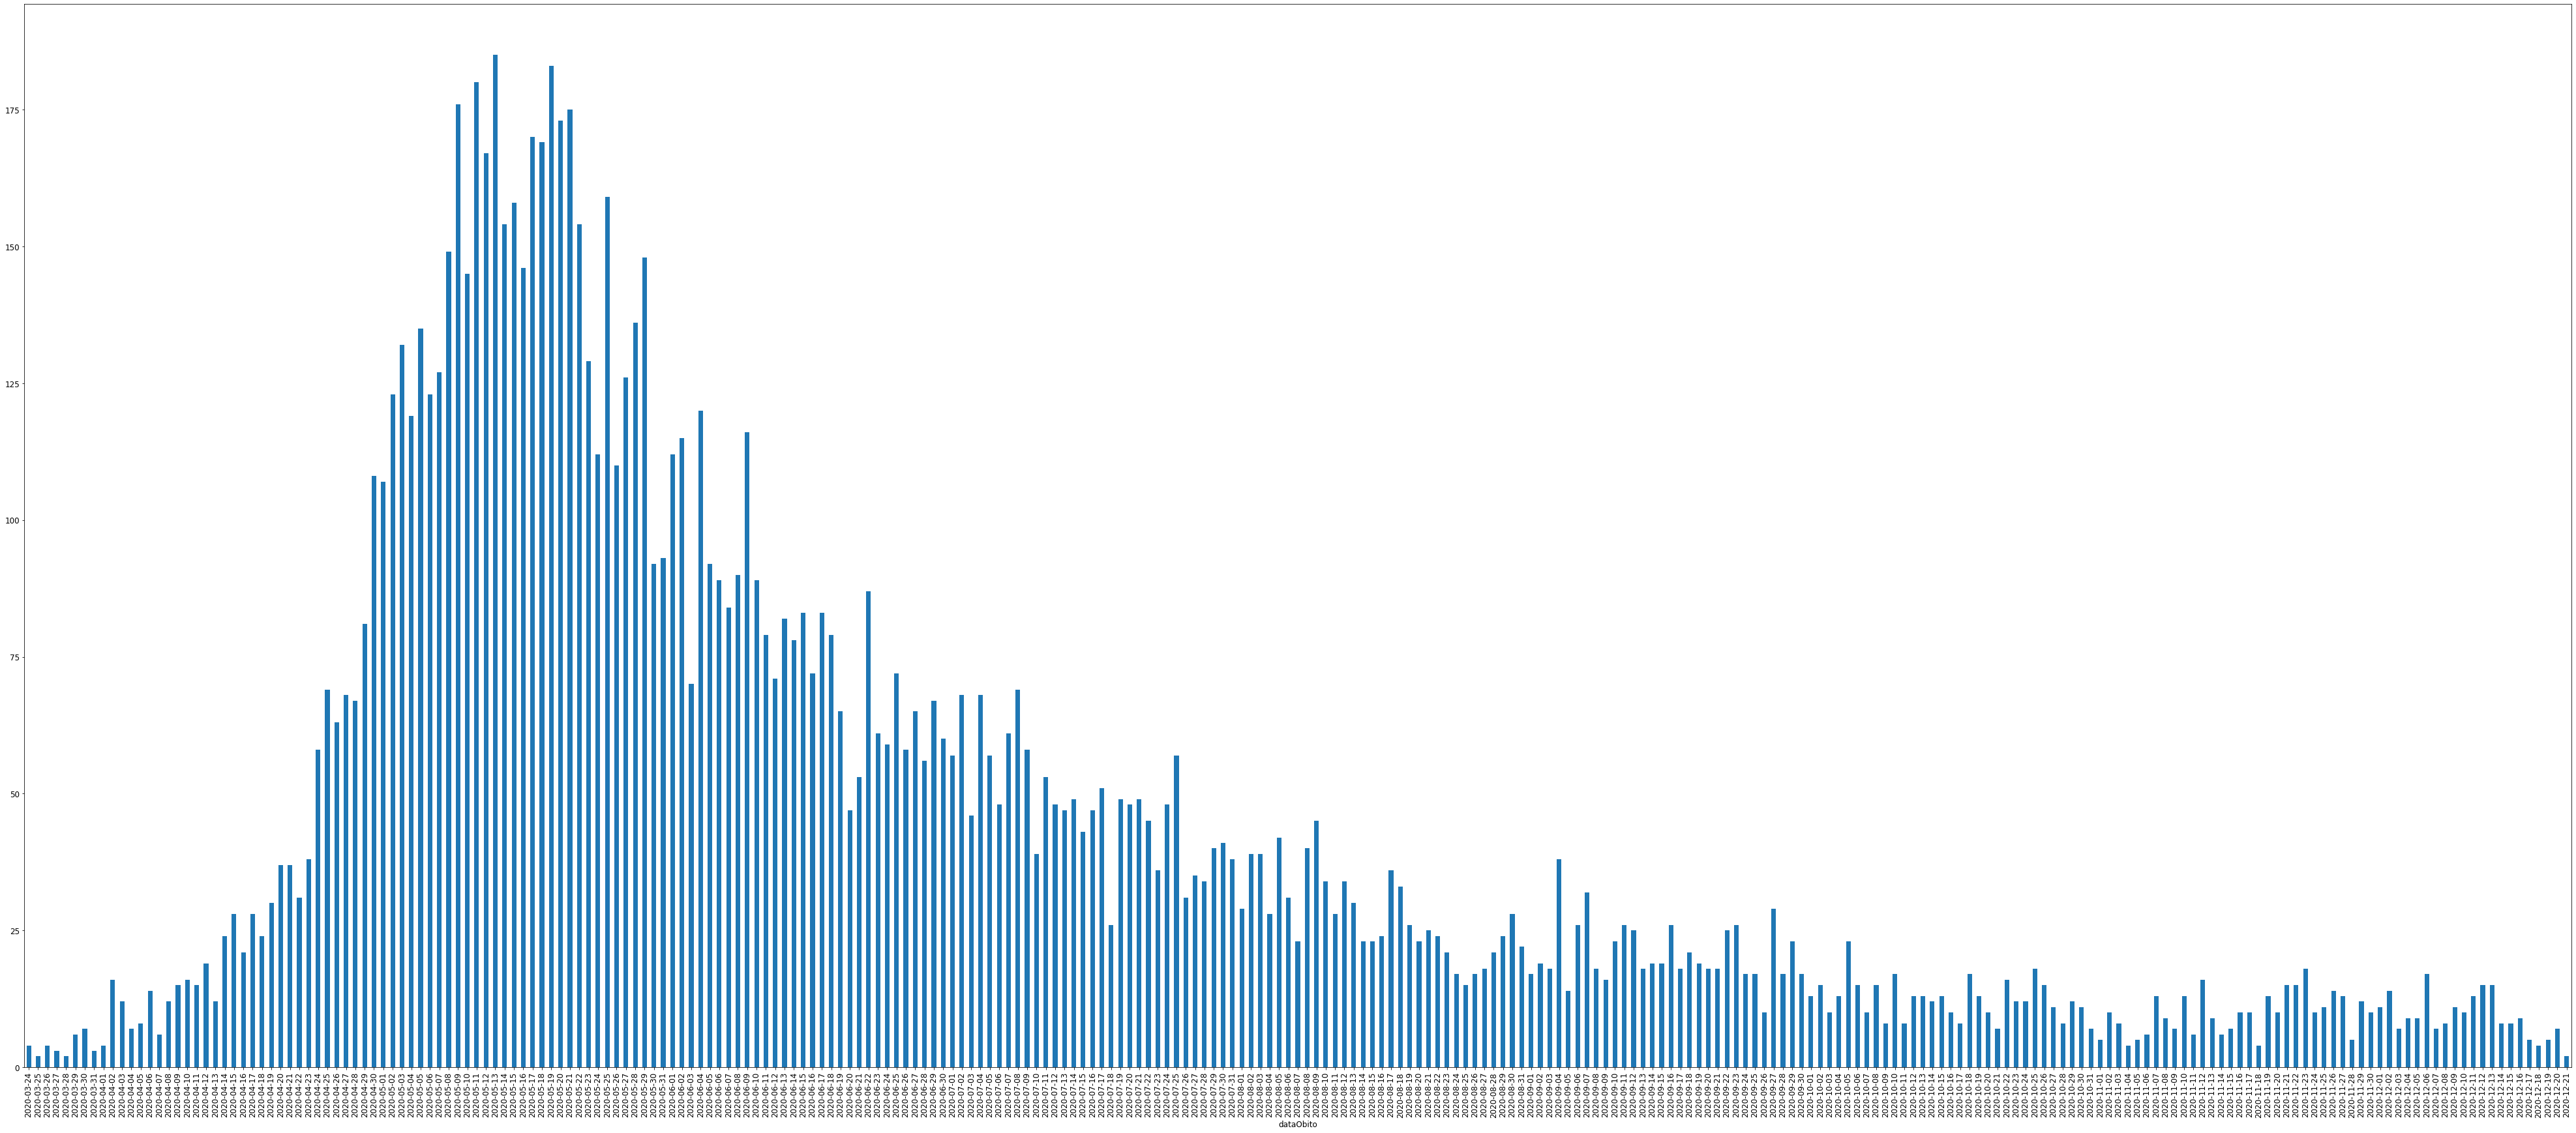

In [259]:
df_ob_graf = group_obito['dataObito']
df_ob_graf.plot(figsize=(70, 30), kind='bar')

In [260]:
group_faixa_idade_obito = df_obitos.groupby(by=df_obitos['faixaIdade']).count()
group_faixa_idade_obito

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeObitoAcumuladoPorDia,qt_obito_dia,mediaMovelObito
faixaIdade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-4,12,0,3,10,0,1,1,1,0,3,10,12,12,12,9,0,12,12,12,12,10,12,6,12,9,12,12,10,10,5,2,10,10,2,2,2,2,2,2,2,3,2,2,2,2,0,0,12,7,12,12,3,3,0,10,0,1,12,12,12,12,11,12,12,12,12,12,12
10-14,9,0,7,6,0,4,4,4,0,7,8,9,9,9,8,0,9,9,9,9,6,7,2,9,8,9,9,6,5,4,0,6,6,4,4,4,4,4,4,4,4,4,4,4,4,0,0,9,6,9,9,5,6,0,6,0,3,9,9,9,9,9,9,9,9,9,9,9
15-19,36,0,18,21,0,12,12,12,0,18,25,36,36,36,30,0,36,36,36,36,29,32,9,36,24,36,36,20,20,12,5,20,20,4,3,3,4,3,3,3,5,3,3,3,3,0,0,36,27,36,36,15,18,1,21,0,12,36,36,36,34,31,36,36,36,36,36,36
20-24,49,0,28,40,0,24,20,21,0,28,41,49,49,49,44,0,49,49,49,49,46,47,14,49,44,49,49,40,36,22,11,39,38,10,9,7,7,8,7,12,8,7,8,6,7,0,0,49,31,49,49,21,28,3,40,0,24,49,49,49,44,35,49,49,49,49,49,49
25-29,80,0,54,69,0,40,30,29,1,54,71,80,80,80,70,0,80,80,80,80,73,78,13,75,60,80,80,64,63,31,18,68,68,11,17,14,14,13,16,19,14,13,19,16,15,0,0,80,48,80,80,39,53,6,69,1,39,80,80,80,79,67,80,80,80,80,80,80
30-34,124,0,79,109,0,64,53,51,3,79,110,124,124,124,106,0,124,124,124,124,118,123,19,112,91,124,124,106,102,65,28,99,96,35,42,35,35,35,38,39,35,36,36,35,42,0,0,123,67,124,124,63,79,9,102,2,65,124,124,124,123,104,124,124,124,124,124,124
35-39,220,0,125,198,0,85,70,71,3,125,202,220,219,220,201,1,220,220,220,220,209,215,50,209,161,220,220,187,181,104,53,188,181,65,78,64,64,63,65,85,66,67,66,66,73,0,0,220,129,220,220,90,123,5,190,1,86,220,220,220,211,172,220,220,220,220,220,220
40-44,298,0,172,258,0,116,106,103,2,172,262,298,298,298,249,0,298,298,298,298,274,293,65,285,214,298,298,245,229,130,78,249,241,73,99,74,74,76,81,109,81,79,84,79,85,0,0,297,181,298,298,120,167,4,252,1,119,298,298,298,290,239,298,298,298,298,298,298
45-49,379,0,224,327,0,139,121,116,5,224,337,378,378,379,328,0,379,379,379,379,352,365,88,360,281,379,379,305,292,148,88,317,311,111,137,113,111,111,119,149,114,113,110,108,118,0,0,378,241,379,379,177,221,0,318,0,140,379,379,379,369,294,379,379,379,379,379,378


**Gráfico 06 - Contagem de óbitos por faixa de idade no período Março - Dezembro 2020 (Resumido)**

In [261]:
counts_obitos_faixa_idade = df_obitos.groupby(['faixaIdade', 'sexoCaso']).faixaIdade.count().unstack()
counts_obitos_faixa_idade

sexoCaso,FEMININO,MASCULINO
faixaIdade,,
0-4,8,4
10-14,3,6
15-19,16,20
20-24,28,21
25-29,28,52
30-34,53,71
35-39,82,138
40-44,93,205
45-49,137,242


**Contagem de óbitos por faixa de idade no período Março - Setembro 2020 (Histogram)**

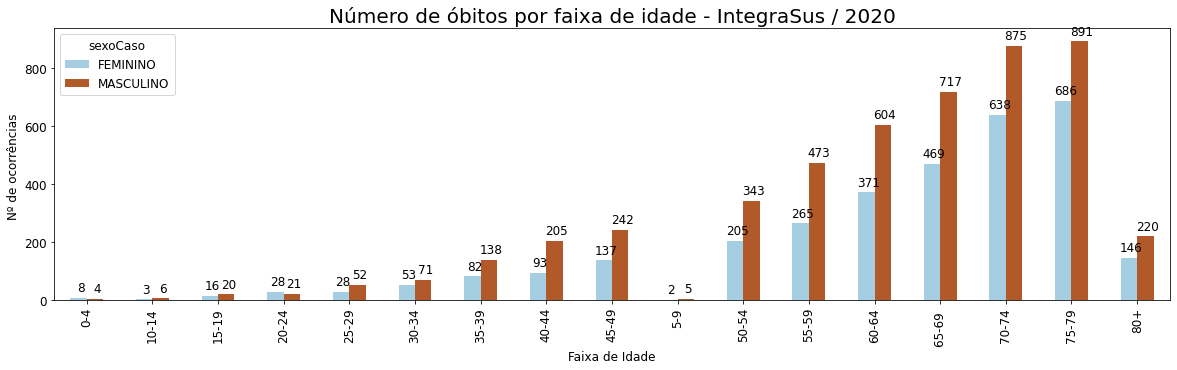

In [262]:
ax = counts_obitos_faixa_idade.plot(kind='bar',stacked = False, colormap = 'Paired', figsize=(20, 5) )

for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')

plt.xlabel ('Faixa de Idade')
plt.ylabel ('Nº de ocorrências ')
plt.title('Número de óbitos por faixa de idade - IntegraSus / 2020',fontsize=20)
plt.show()

**Conferência para o gráfico acima**


In [263]:
group_faixa_idade_obito = df_obitos.groupby('faixaIdade')
group_faixa_idade_obito['faixaIdade'].count()

faixaIdade
0-4         12
10-14        9
15-19       36
20-24       49
25-29       80
30-34      124
35-39      220
40-44      298
45-49      379
5-9          7
50-54      548
55-59      738
60-64      975
65-69     1186
70-74     1513
75-79     1577
80+        366
Name: faixaIdade, dtype: int64

**Gráfico 07 - Ocorrências de óbito por sexo do paciente (Histogram)**

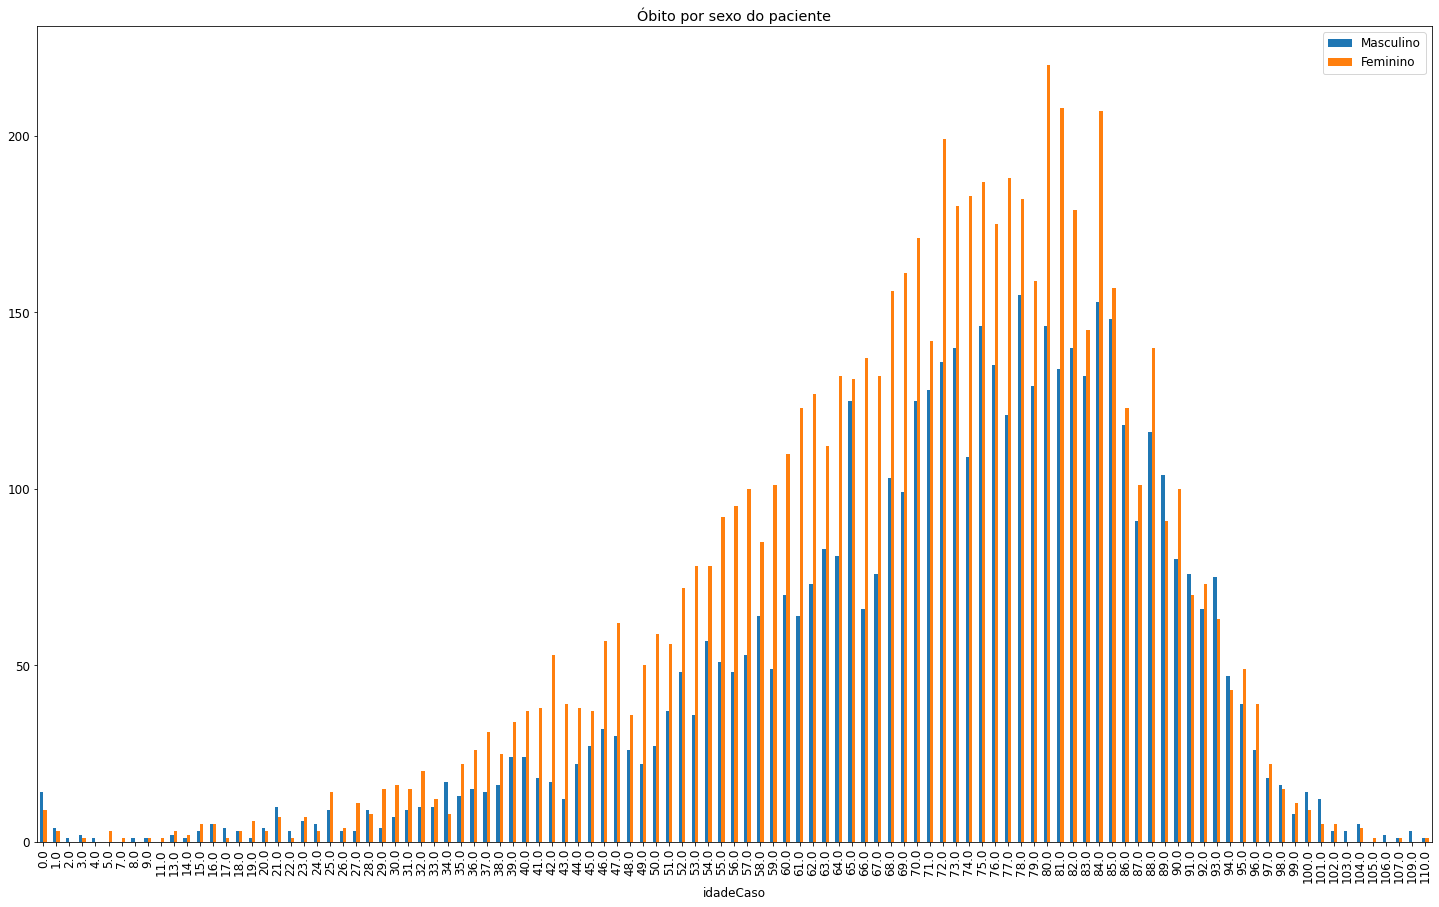

In [264]:
obito_by_sex = df_obitos.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')
obito_by_sex.columns = ['Masculino', 'Feminino']
obito_by_sex.plot.bar(title='Óbito por sexo do paciente', figsize=(25,15) )

**Fazer o mesmo acima por faixa de idade**

**Gráfico 08 - Distribuição de óbitos por raça/cor do paciente (Pie)**

In [265]:
df_obitos.head(2)

,identificadorCaso,idRedcap,idEsus,idSivep,classificacaoEstadoRedcap,classificacaoEstadoEsus,classificacaoFinalEsus,evolucaoCasoEsus,cboEsus,profissionalSaudeEsus,paisCaso,estadoCaso,codigoMunicipioCaso,municipioCaso,bairroCaso,bairroCasoGeocoder,sexoCaso,idadeCaso,faixaEtaria,dataNascimento,dataNotificacao,dataInicioSintomas,dataSolicitacaoExame,dataColetaExame,dataResultadoExame,resultadoFinalExame,laboratorioExame,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUTISivep,dataSaidaUTISivep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeHepaticaSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoTesteExame,requisicaoGal,racaCor,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,tipoObitoMaterno,classificacaoFinalCasoSivep,gestante,tipoTesteEsus,obitoConfirmado,dataObito,classificacaoObito,localObito,tipoLocalObito,faixaIdade,qtObito,qtCasoConfirmado,qtCasoConfirmadoSemObito,qtdeObitoAcumuladoPorDia,qt_obito_dia,mediaMovelObito
11478,c7a534be5edb22fccdc845c2a6a8085a,NaN,232001023852,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,CE,230440.0,FORTALEZA,AEROLANDIA,NaN,MASCULINO,47.0,45 a 49 anos,1973-07-08,2020-05-12,2020-05-04,NaT,2020-05-11 06:00:00,2020-05-11,Positivo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.022290e+11,Parda,2020-06-01 09:58:51.613,NaN,FORTALEZA,NaN,NaN,NaN,NaN,True,2020-05-17,Confirmado,HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STU...,PÚBLICA,45-49,1.0,1.0,0.0,170.0,170.0,NaN
22759,3b9a0ede6b82f292b5d929a545f8fd3d,NaN,232005151576,NaN,NaN,Positivo,Confirmado Laboratorial,Óbito,NaN,False,NaN,CE,230690.0,JAGUARIBE,ZONA RURAL,NaN,MASCULINO,86.0,80 ou mais,1933-12-05,2020-06-21,2020-06-11,NaT,2020-06-21 03:00:00,2020-06-21,Positivo,GAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT-PCR,2.010020e+11,Parda,2020-07-04 10:24:12.563,NaN,JAGUARIBE,NaN,NaN,NaN,RT-PCR,True,2020-07-02,Confirmado,HOSPITAL SAO RAIMUNDO,PÚBLICA,NaN,1.0,1.0,0.0,68.0,68.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3359a399e8>,
      dtype=object)

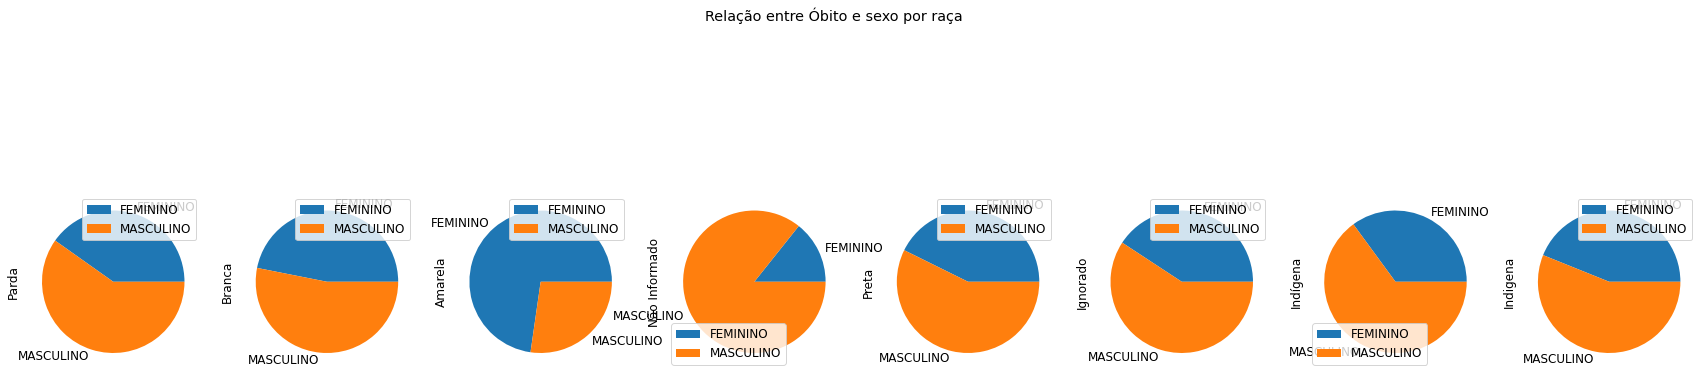

In [266]:
obito_by_sexo = df_obitos.groupby([ 'sexoCaso', 'racaCor']).size().unstack('racaCor')
obito_by_sexo.columns =  ['Parda','Branca','Amarela', 'Não Informado','Preta','Ignorado','Indígena', 'Indigena']


obito_by_sexo.plot.pie(title='Relação entre Óbito e sexo por raça', figsize=(30,8) , subplots = True  )

**Gráficos 9 - Distribuição de óbitos por faixa de idade do paciente(histogram)**

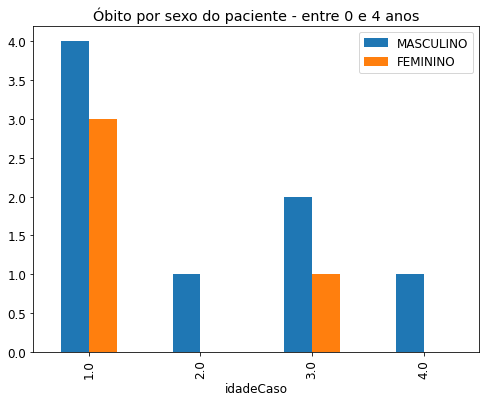

In [267]:
df_obit_faixa1 = df_obitos.loc[ (df_obitos['faixaIdade'] == '0-4')]
df_obit_plot_faixa1 = df_obit_faixa1.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')
df_obit_plot_faixa1.columns = ['MASCULINO', 'FEMININO']
df_obit_plot_faixa1.plot.bar(title='Óbito por sexo do paciente - entre 0 e 4 anos', figsize=(8,6) )

In [274]:
df_obit_faixa3 = df_obitos.loc[ (df_obitos['faixaIdade'] == '10-14')]
df_obit_plot_faixa3 = df_obit_faixa3.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa4 = df_obitos.loc[ (df_obitos['faixaIdade'] == '15-19')]
df_obit_plot_faixa4 = df_obit_faixa4.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa5 = df_obitos.loc[ (df_obitos['faixaIdade'] == '20-24')]
df_obit_plot_faixa5 = df_obit_faixa5.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa6 = df_obitos.loc[ (df_obitos['faixaIdade'] == '25-29')]
df_obit_plot_faixa6 = df_obit_faixa6.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa7 = df_obitos.loc[ (df_obitos['faixaIdade'] == '30-34')]
df_obit_plot_faixa7 = df_obit_faixa7.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa8 = df_obitos.loc[ (df_obitos['faixaIdade'] == '35-39')]
df_obit_plot_faixa8 = df_obit_faixa8.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa9 = df_obitos.loc[ (df_obitos['faixaIdade'] == '40-44')]
df_obit_plot_faixa9 = df_obit_faixa9.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa10 = df_obitos.loc[ (df_obitos['faixaIdade'] == '45-49')]
df_obit_plot_faixa10 = df_obit_faixa10.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa11 = df_obitos.loc[ (df_obitos['faixaIdade'] == '50-54')]
df_obit_plot_faixa11 = df_obit_faixa11.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa12 = df_obitos.loc[ (df_obitos['faixaIdade'] == '55-59')]
df_obit_plot_faixa12 = df_obit_faixa12.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa13 = df_obitos.loc[ (df_obitos['faixaIdade'] == '60-64')]
df_obit_plot_faixa13 = df_obit_faixa13.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa14 = df_obitos.loc[ (df_obitos['faixaIdade'] == '60-64')]
df_obit_plot_faixa14 = df_obit_faixa14.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa15 = df_obitos.loc[ (df_obitos['faixaIdade'] == '70-74')]
df_obit_plot_faixa15 = df_obit_faixa15.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa16 = df_obitos.loc[ (df_obitos['faixaIdade'] == '75-79')]
df_obit_plot_faixa16 = df_obit_faixa16.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')

df_obit_faixa17 = df_obitos.loc[ (df_obitos['faixaIdade'] == '80+')]
df_obit_plot_faixa17 = df_obit_faixa17.groupby(['idadeCaso', 'sexoCaso']).size().unstack('sexoCaso')




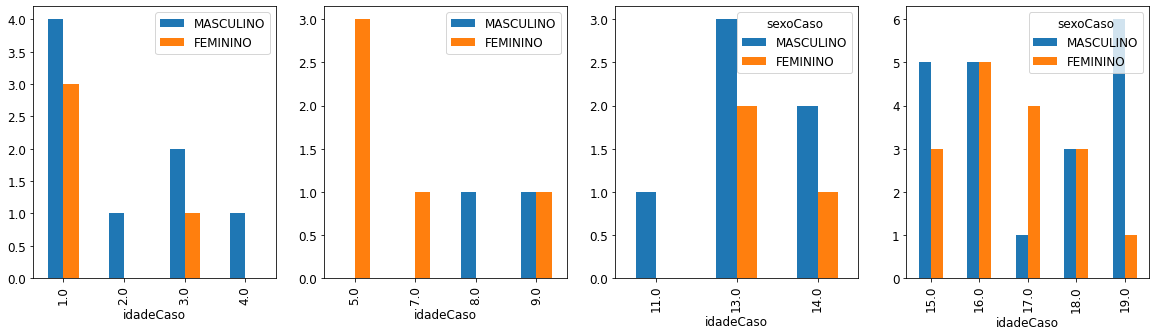

In [275]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

df_obit_plot_faixa1[["MASCULINO","FEMININO"]].plot(ax=axes[0], kind='bar')
df_obit_plot_faixa2[["MASCULINO","FEMININO"]].plot(ax=axes[1], kind='bar')
df_obit_plot_faixa3[["MASCULINO","FEMININO"]].plot(ax=axes[2], kind='bar')
df_obit_plot_faixa4[["MASCULINO","FEMININO"]].plot(ax=axes[3], kind='bar')


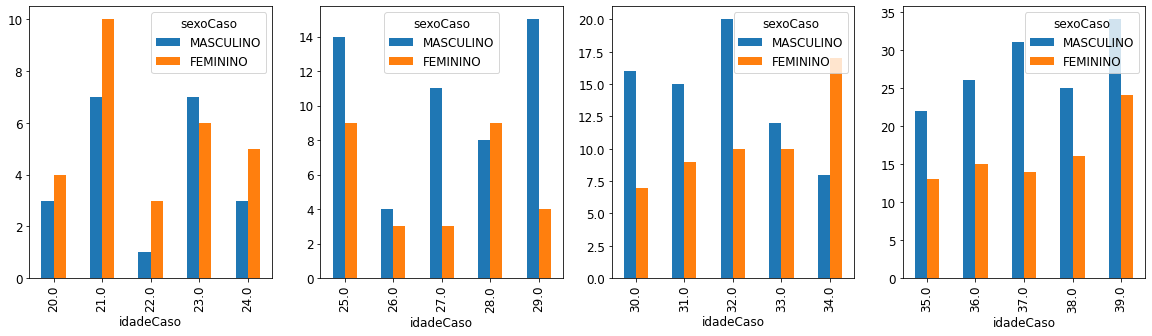

In [276]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

df_obit_plot_faixa5[["MASCULINO","FEMININO"]].plot(ax=axes[0], kind='bar')
df_obit_plot_faixa6[["MASCULINO","FEMININO"]].plot(ax=axes[1], kind='bar')
df_obit_plot_faixa7[["MASCULINO","FEMININO"]].plot(ax=axes[2], kind='bar')
df_obit_plot_faixa8[["MASCULINO","FEMININO"]].plot(ax=axes[3], kind='bar')

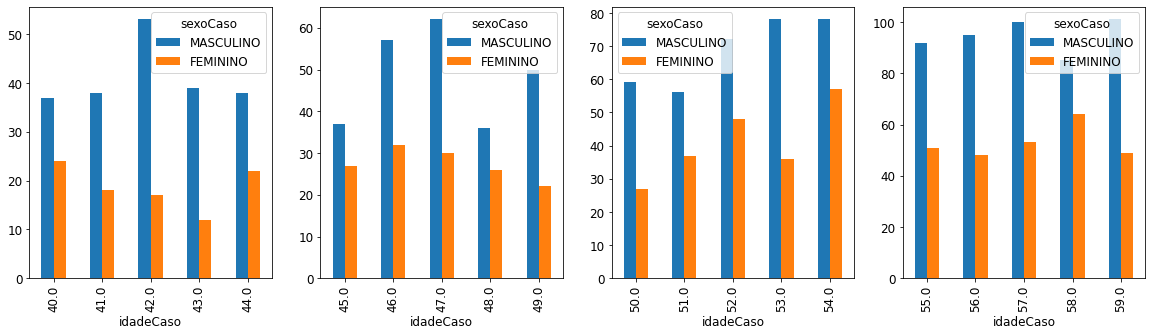

In [277]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

df_obit_plot_faixa9[["MASCULINO","FEMININO"]].plot(ax=axes[0], kind='bar')
df_obit_plot_faixa10[["MASCULINO","FEMININO"]].plot(ax=axes[1], kind='bar')
df_obit_plot_faixa11[["MASCULINO","FEMININO"]].plot(ax=axes[2], kind='bar')
df_obit_plot_faixa12[["MASCULINO","FEMININO"]].plot(ax=axes[3], kind='bar')

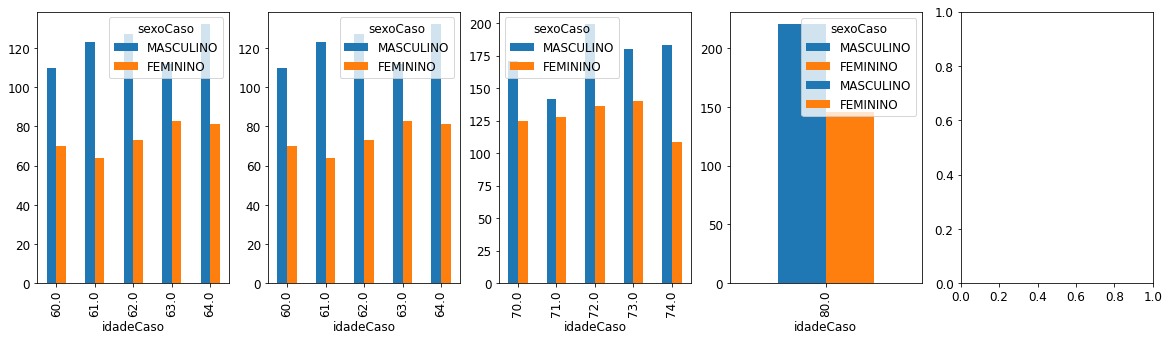

In [281]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

df_obit_plot_faixa13[["MASCULINO","FEMININO"]].plot(ax=axes[0], kind='bar')
df_obit_plot_faixa14[["MASCULINO","FEMININO"]].plot(ax=axes[1], kind='bar')
df_obit_plot_faixa15[["MASCULINO","FEMININO"]].plot(ax=axes[2], kind='bar')
df_obit_plot_faixa16[["MASCULINO","FEMININO"]].plot(ax=axes[3], kind='bar')
df_obit_plot_faixa17[["MASCULINO","FEMININO"]].plot(ax=axes[3], kind='bar')

